* 1. Load the libries and Data For the project

In [2]:
import warnings
warnings.filterwarnings('ignore')

from IPython.display import display, HTML
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
import time
import math

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV

from sklearn.linear_model import LinearRegression
from sklearn.svm import SVC, LinearSVC,SVR
from sklearn.metrics import r2_score
import xgboost as xgb
from xgboost import XGBRegressor 

# Preprocessing
from sklearn.preprocessing import MinMaxScaler,PolynomialFeatures
from sklearn import preprocessing
# Modelling Helpers
from sklearn.preprocessing import Imputer , Normalizer , scale
from sklearn.cross_validation import train_test_split , StratifiedKFold
from sklearn.feature_selection import RFECV

#Imputation
#from fancyimpute import BiScaler, KNN

# Metrics
from sklearn.metrics import make_scorer
from sklearn.metrics import mean_squared_error

# Visualisation
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import seaborn as sns

# Configure visualisations
%matplotlib inline
mpl.style.use( 'ggplot' )
sns.set_style( 'white' )
pylab.rcParams[ 'figure.figsize' ] = 8 , 6

#Load the data from csv
store = pd.read_csv('./input/store.csv')
train = pd.read_csv('./input/train.csv', parse_dates=["Date"],keep_date_col=True)
test = pd.read_csv('./input/test.csv', parse_dates=["Date"],keep_date_col=True)

#Data information Analysis including the data type and how many observations etc.
display(store.info())
display(train.info())

/Users/roy/Documents/workplace/env/lib/python2.7/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1115 entries, 0 to 1114
Data columns (total 10 columns):
Store                        1115 non-null int64
StoreType                    1115 non-null object
Assortment                   1115 non-null object
CompetitionDistance          1112 non-null float64
CompetitionOpenSinceMonth    761 non-null float64
CompetitionOpenSinceYear     761 non-null float64
Promo2                       1115 non-null int64
Promo2SinceWeek              571 non-null float64
Promo2SinceYear              571 non-null float64
PromoInterval                571 non-null object
dtypes: float64(5), int64(2), object(3)
memory usage: 87.2+ KB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 9 columns):
Store            1017209 non-null int64
DayOfWeek        1017209 non-null int64
Date             1017209 non-null datetime64[ns]
Sales            1017209 non-null int64
Customers        1017209 non-null int64
Open             1017209 non-null int64
Promo            1017209 non-null int64
StateHoliday     1017209 non-null object
SchoolHoliday    1017209 non-null int64
dtypes: datetime64[ns](1), int64(7), object(1)
memory usage: 69.8+ MB


None

In [3]:
#Create some helpers functions

def create_feature_map(features):
    outfile = open('xgb.fmap', 'w')
    for i, feat in enumerate(features):
        outfile.write('{0}\t{1}\tq\n'.format(i, feat))
    outfile.close()
    
def normalize(x):

    xmin = x.min()
    xmax = x.max()
    
    x = (x-xmin)/(xmax-xmin)

    return x

#def rmspe_score(y_pred,y_true):
#    return float(np.sqrt(np.mean((1-y_pred/y_true)**2)))

#def rmspe(y_pred,dtrain):
#    labels = dtrain.get_label()
#    return 'RMSPE',float(np.sqrt(np.mean((1-y_pred/labels)**2)))


# Thanks to Chenglong Chen for providing this in the forum
def ToWeight(y):
    w = np.zeros(y.shape, dtype=float)
    ind = y != 0
    w[ind] = 1./(y[ind]**2)
    return w

def metrics_rmspe(y,yhat):
    w = ToWeight(y)
    rmspe = np.sqrt(np.mean( w * (y - yhat)**2 ))
    return rmspe

def rmspe_score(yhat, y):
    w = ToWeight(y)
    rmspe = np.sqrt(np.mean( w * (y - yhat)**2 ))
    return rmspe

def rmspe(yhat, y):
    # y = y.values
    y = y.get_label()
    y = np.exp(y) - 1
    yhat = np.exp(yhat) - 1
    w = ToWeight(y)
    rmspe = np.sqrt(np.mean(w * (y - yhat)**2))
    return "rmspe", rmspe

def minmaxscaler(df):
    return 

def plot_correlation_map( df ):
    corr = df.corr()
    _ , ax = plt.subplots( figsize =( 12 , 10 ) )
    cmap = sns.diverging_palette( 220 , 10 , as_cmap = True )
    _ = sns.heatmap(
        corr, 
        cmap = cmap,
        square=True, 
        cbar_kws={ 'shrink' : .9 }, 
        ax=ax, 
        annot = True, 
        annot_kws = { 'fontsize' : 12 }
    )

def percentage_annotate_helper(ax,df):
    for p in ax.patches:
        x=p.get_bbox().get_points()[:,0]
        y=p.get_bbox().get_points()[1,1]
        ax.annotate('{:.1f}%'.format(100.*y/len(df)), (x.mean(), y),
                       ha='center', va='bottom') # set the alignment of the text

def outliers_detector(df,feature):
    Q1 = np.percentile(df[feature],25) 
    Q2 = np.percentile(df[feature],50)
    Q3 = np.percentile(df[feature],75)
    step = 1.5 * (Q3-Q1)
    print("Data points considered outliers for the feature '{}':".format(feature))
    display(df[~((df[feature] >= Q1 - step) & (df[feature] <= Q3 + step))])
    return df[~((df[feature] >= Q1 - step) & (df[feature] <= Q3 + step))].index.values

def plotModelResults(model, X_train, X_test,y_test,plot_intervals=False, plot_anomalies=False):
    """
        Plots modelled vs fact values, prediction intervals and anomalies
    
    """
    
    prediction = model.predict(X_test)
    
    plt.figure(figsize=(15, 7))
    plt.plot(prediction, "g", label="prediction", linewidth=2.0)
    plt.plot(y_test.values, label="actual", linewidth=2.0)
    
    if plot_intervals:
        cv = cross_val_score(model, X_train, y_train, 
                                    cv=tscv, 
                                    scoring="neg_mean_absolute_error")
        mae = cv.mean() * (-1)
        deviation = cv.std()
        
        scale = 1.96
        lower = prediction - (mae + scale * deviation)
        upper = prediction + (mae + scale * deviation)
        
        plt.plot(lower, "r--", label="upper bond / lower bond", alpha=0.5)
        plt.plot(upper, "r--", alpha=0.5)
        
        if plot_anomalies:
            anomalies = np.array([np.NaN]*len(y_test))
            anomalies[y_test<lower] = y_test[y_test<lower]
            anomalies[y_test>upper] = y_test[y_test>upper]
            plt.plot(anomalies, "o", markersize=10, label = "Anomalies")
    
    error = rmspe_score(y_test,prediction)
    plt.title("Mean absolute percentage error {0:.2f}%".format(float(error[1])))
    plt.legend(loc="best")
    plt.tight_layout()
    plt.grid(True);
    
def plotCoefficients(model):
    """
        Plots sorted coefficient values of the model
    """
    
    coefs = pd.DataFrame(model.coef_, X_train.columns)
    coefs.columns = ["coef"]
    coefs["abs"] = coefs.coef.apply(np.abs)
    coefs = coefs.sort_values(by="abs", ascending=False).drop(["abs"], axis=1)
    
    plt.figure(figsize=(15, 7))
    coefs.coef.plot(kind='bar')
    plt.grid(True, axis='y')
    plt.hlines(y=0, xmin=0, xmax=len(coefs), linestyles='dashed');
    
def modelfit(alg, dtrain, predictors,target,useTrainCV=True, cv_folds=5, early_stopping_rounds=50):
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(dtrain[predictors].values, label=dtrain[target].values)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
            feval=rmspe, early_stopping_rounds=early_stopping_rounds)
        alg.set_params(n_estimators=cvresult.shape[0])
    
    #Fit the algorithm on the data
    alg.fit(dtrain[predictors], dtrain[target],eval_metric=rmspe)
        
    #Predict training set:
    dtrain_predictions = alg.predict(dtrain[predictors])
    #dtrain_predprob = alg.predict_proba(dtrain[predictors])[:,1]
        
    #Print model report:
    print("\nModel Report")
    print("RMSPE : %.4f" % rmspe_score(dtrain_predictions,dtrain[target].values))
                    
    feat_imp = pd.Series(alg.feature_importances_).sort_values(ascending=False)
    feat_imp.plot(kind='barh', title='Feature Importances')
    plt.ylabel('Feature Importance Score')


In [10]:
display(test.info())
display(test.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41088 entries, 0 to 41087
Data columns (total 8 columns):
Id               41088 non-null int64
Store            41088 non-null int64
DayOfWeek        41088 non-null int64
Date             41088 non-null datetime64[ns]
Open             41077 non-null float64
Promo            41088 non-null int64
StateHoliday     41088 non-null object
SchoolHoliday    41088 non-null int64
dtypes: datetime64[ns](1), float64(1), int64(5), object(1)
memory usage: 2.5+ MB


None

,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday
0,1,1,4,2015-09-17,1.0,1,0,0
1,2,3,4,2015-09-17,1.0,1,0,0
2,3,7,4,2015-09-17,1.0,1,0,0
3,4,8,4,2015-09-17,1.0,1,0,0
4,5,9,4,2015-09-17,1.0,1,0,0


In [104]:
mask = train[(train.DayOfWeek!=7) & (train.Open==0) & (train.StateHoliday==0) & (train.SchoolHoliday==0)].groupby(train.Store).count()
display(mask[mask.Store>3])

display(train[(train.Store==390) & (train.DayOfWeek!=7) & (train.Open==0) & (train.StateHoliday==0) & (train.SchoolHoliday==0)])


,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
Store,,,,,,,,,
25,21,21,21,21,21,21,21,21,21
123,6,6,6,6,6,6,6,6,6
145,5,5,5,5,5,5,5,5,5
227,11,11,11,11,11,11,11,11,11
357,12,12,12,12,12,12,12,12,12
376,8,8,8,8,8,8,8,8,8
390,4,4,4,4,4,4,4,4,4
623,4,4,4,4,4,4,4,4,4
708,30,30,30,30,30,30,30,30,30


,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
561564,390,4,2014-02-13,0,0,0,0,0,0
562679,390,3,2014-02-12,0,0,0,0,0,0
563794,390,2,2014-02-11,0,0,0,0,0,0
564909,390,1,2014-02-10,0,0,0,0,0,0


,Store,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
StoreType,,,,,,,,,
a,602,602,601,426,426,602,289,289,289
b,17,17,17,9,9,17,5,5,5
c,148,148,148,107,107,148,75,75,75
d,348,348,346,219,219,348,202,202,202


In [72]:
#Data Clean up

#Check for some missing values
#print store.isnull().sum()
store['CompetitionDistance'].fillna(0,inplace=True)
store['Promo2SinceWeek'].fillna(0,inplace=True)
store['Promo2SinceYear'].fillna(0,inplace=True)
store['PromoInterval'].fillna('n',inplace=True)
store['CompetitionOpenSinceMonth'].fillna(0,inplace=True)
store['CompetitionOpenSinceYear'].fillna(0,inplace=True)
#display(store[store['CompetitionDistance']==0].count())
#display(store[store['CompetitionOpenSinceMonth']==0].count())
#display(store[store['CompetitionOpenSinceYear']==0].count())
#print store.isnull().sum()

#store = pd.get_dummies(store,columns=['StoreType','Assortment','PromoInterval'])
#store[store['CompetitionOpenSinceMonth'].isnull()].head()
#sns.distplot(store['CompetitionOpenSinceYear'])

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval


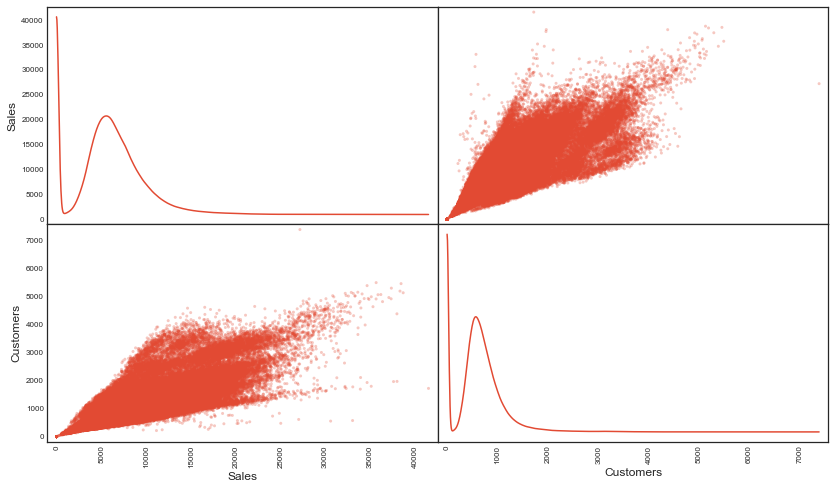

In [17]:
pd.plotting.scatter_matrix(train.fillna(0)[['Sales','Customers']], alpha = 0.3, figsize = (14,8), diagonal = 'kde');
#outliers_detector(store,'CompetitionDistance')
#store['Promo2SinceWeek'].describe()
#np.log1p(store['Promo2SinceWeek']).describe()

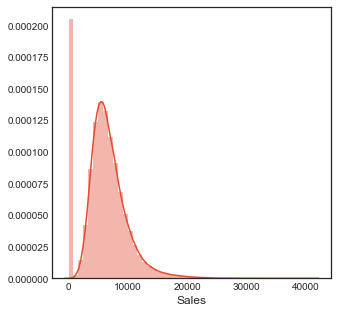

In [20]:
_,ax = plt.subplots(figsize=(5,5))
sns.distplot((train['Sales']),ax=ax)

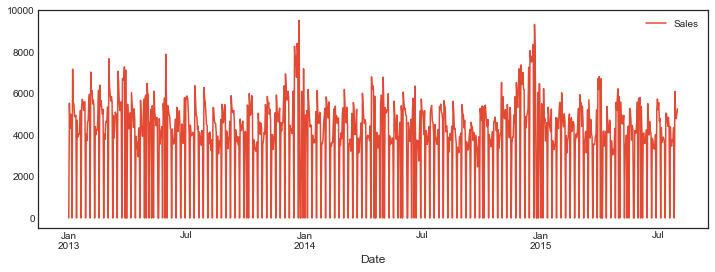

In [68]:
_,ax = plt.subplots(figsize=(20,10))
sales = train[(train['Store']==1)][['Date','Sales']]
#print sales.describe()
#sales['Date'] = pd.to_datetime(sales['Date'])
sales=sales.set_index(sales['Date'])
sales.drop(['Date'],axis=1,inplace=True)
sales.plot(figsize = (12, 4),ax=ax)
#ax.set_ylim(0,)
#plt.show()


sales = sales.asfreq('d',method='pad')

from statsmodels.tsa.seasonal import seasonal_decompose
#result = seasonal_decompose(sales, model='multiplicative')
#result.plot()
#plt.show()

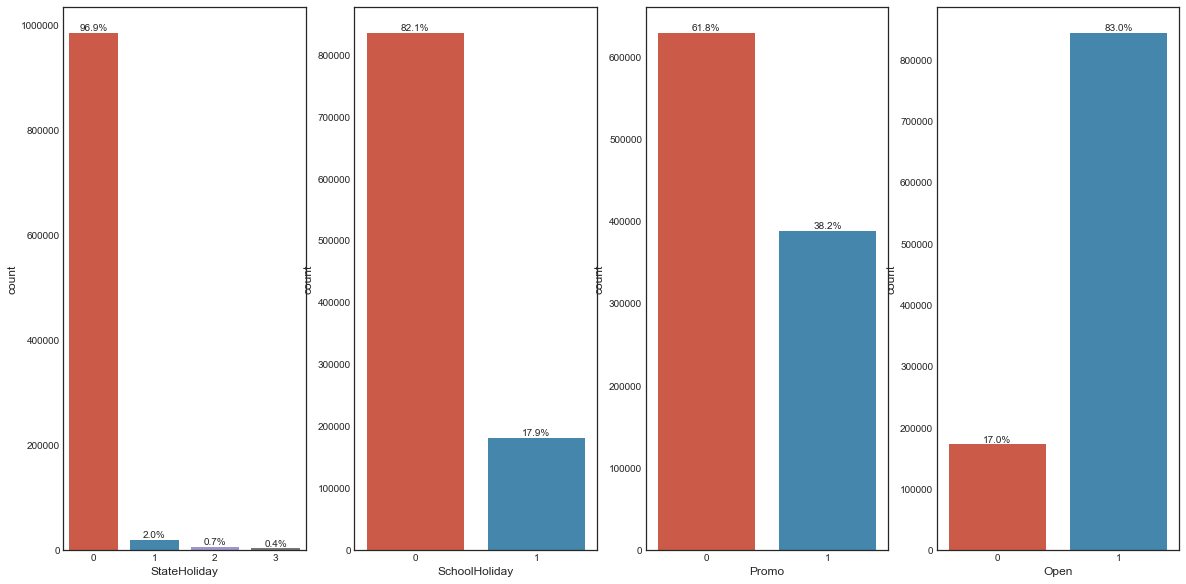

In [81]:
#print train.isnull().sum()
#print store.isnull().sum()

_,ax = plt.subplots(1,4,figsize=(20,10))

ax = ax.ravel()
#ax[0] = sns.barplot(x="StateHoliday", y="Values", data=train, estimator=lambda x: len(x) / len(train) * 100)
train['StateHoliday'] = train['StateHoliday'].replace('a',1)
train['StateHoliday'] = train['StateHoliday'].replace('b',2)
train['StateHoliday'] = train['StateHoliday'].replace('c',3)
train['StateHoliday'] = pd.to_numeric(train['StateHoliday'], downcast='integer')
sns.countplot(data=train,x='StateHoliday',ax=ax[0])
percentage_annotate_helper(ax[0],train['StateHoliday'])
sns.countplot(data=train,x='SchoolHoliday',ax=ax[1])
percentage_annotate_helper(ax[1],train['SchoolHoliday'])
sns.countplot(data=train,x='Promo',ax=ax[2])
percentage_annotate_helper(ax[2],train['Promo'])
sns.countplot(data=train,x='Open',ax=ax[3])
percentage_annotate_helper(ax[3],train['Open'])

no_sales_with_customers = train.index[(train.Sales==0) & (train.Customers>0)].tolist()
#Drop rare cases
train.drop(no_sales_with_customers,inplace=True)

#print store.columns
#index = store['CompetitionDistance'].index[store['CompetitionDistance'].apply(np.isnan)]
#print store.describe()
#store['CompetitionDistance'].fillna(0,inplace=True)
#store['PromoInterval'].fillna('no',inplace=True)

#print store[store['Promo2']==1].count()
#sns.countplot(data=store,x='StoreType',ax=ax[0,0])
#sns.countplot(data=store,x='Assortment',ax=ax[0,1])
#sns.countplot(data=store,x='PromoInterval',ax=ax[0,2])
#sns.countplot(data=store,x='')
#sns.distplot(store.Promo2)
#sns.distplot(store.CompetitionDistance,ax=ax[1,0])




In [102]:
train_data = pd.merge(train,store,on='Store')

display(train_data.info())

#print train_data['Date'].head()
train_data['Date'] = pd.to_datetime(train_data['Date'])
train_data.set_index(train_data['Date'],inplace=True)
train_data['Day']=train_data['Date'].map(lambda x:x.day).astype(float)
train_data['Month'] = train_data['Date'].map(lambda x: x.month)
train_data['Year'] = train_data['Date'].map(lambda x: x.year)
train_data['Week'] = train_data['Date'].map(lambda x: x.strftime("%V"))
train_data['Week']=pd.to_numeric(train_data['Week'], downcast='integer')
train_data['Season'] = train_data['Date'].map(lambda x: 1 if x.month in [1,2,3] else (2 if x.month in [4,5,6] else (3 if x.month in [7,8,9] else 4)))
train_data['CompetitionDistance'].fillna(0,inplace=True)
train_data["CompetitionMonthDuration"] = (train_data['Month']-train_data['CompetitionOpenSinceMonth'])+(train_data['Year']-train_data['CompetitionOpenSinceYear'])*12
train_data["Promo2WeekDuration"] = (train_data['Week']-train_data['Promo2SinceWeek'])/4+(train_data['Year']-train_data['Promo2SinceYear'])*12
train_data["CompetitionMonthDuration"].fillna(0,inplace=True)
train_data["Promo2WeekDuration"].fillna(0,inplace=True)
train_data['PromoInterval'].fillna('n',inplace=True)
#train_data.drop(['CompetitionOpenSinceMonth','CompetitionOpenSinceYear','Promo2SinceWeek','Promo2SinceYear'],axis=1,inplace=True)

train_data['Sales'] = train_data['Sales']*1.0

#train_data.describe()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1017207 entries, 0 to 1017206
Data columns (total 18 columns):
Store                        1017207 non-null int64
DayOfWeek                    1017207 non-null int64
Date                         1017207 non-null datetime64[ns]
Sales                        1017207 non-null int64
Customers                    1017207 non-null int64
Open                         1017207 non-null int64
Promo                        1017207 non-null int64
StateHoliday                 1017207 non-null int8
SchoolHoliday                1017207 non-null int64
StoreType                    1017207 non-null object
Assortment                   1017207 non-null object
CompetitionDistance          1014565 non-null float64
CompetitionOpenSinceMonth    693861 non-null float64
CompetitionOpenSinceYear     693861 non-null float64
Promo2                       1017207 non-null int64
Promo2SinceWeek              509177 non-null float64
Promo2SinceYear              509177 non-

None

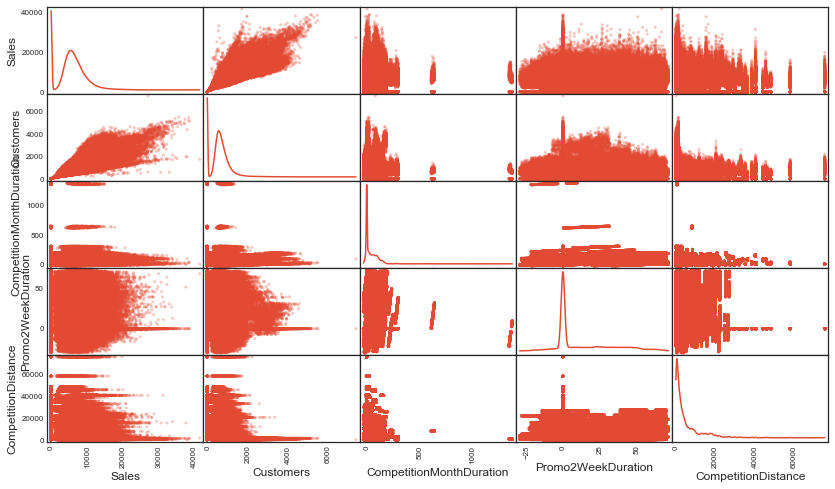

In [101]:
pd.plotting.scatter_matrix(train_data.fillna(0)[['Sales','Customers','CompetitionMonthDuration','Promo2WeekDuration','CompetitionDistance']], alpha = 0.3, figsize = (14,8), diagonal = 'kde');

In [100]:
train_data.groupby([train_data.StoreType,train_data.Assortment]).count()
display(train_data.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1017207 entries, 2015-07-31 to 2013-01-01
Data columns (total 25 columns):
Store                        1017207 non-null int64
DayOfWeek                    1017207 non-null int64
Date                         1017207 non-null datetime64[ns]
Sales                        1017207 non-null float64
Customers                    1017207 non-null int64
Open                         1017207 non-null int64
Promo                        1017207 non-null int64
StateHoliday                 1017207 non-null int8
SchoolHoliday                1017207 non-null int64
StoreType                    1017207 non-null object
Assortment                   1017207 non-null object
CompetitionDistance          1017207 non-null float64
CompetitionOpenSinceMonth    693861 non-null float64
CompetitionOpenSinceYear     693861 non-null float64
Promo2                       1017207 non-null int64
Promo2SinceWeek              509177 non-null float64
Promo2SinceYear        

None

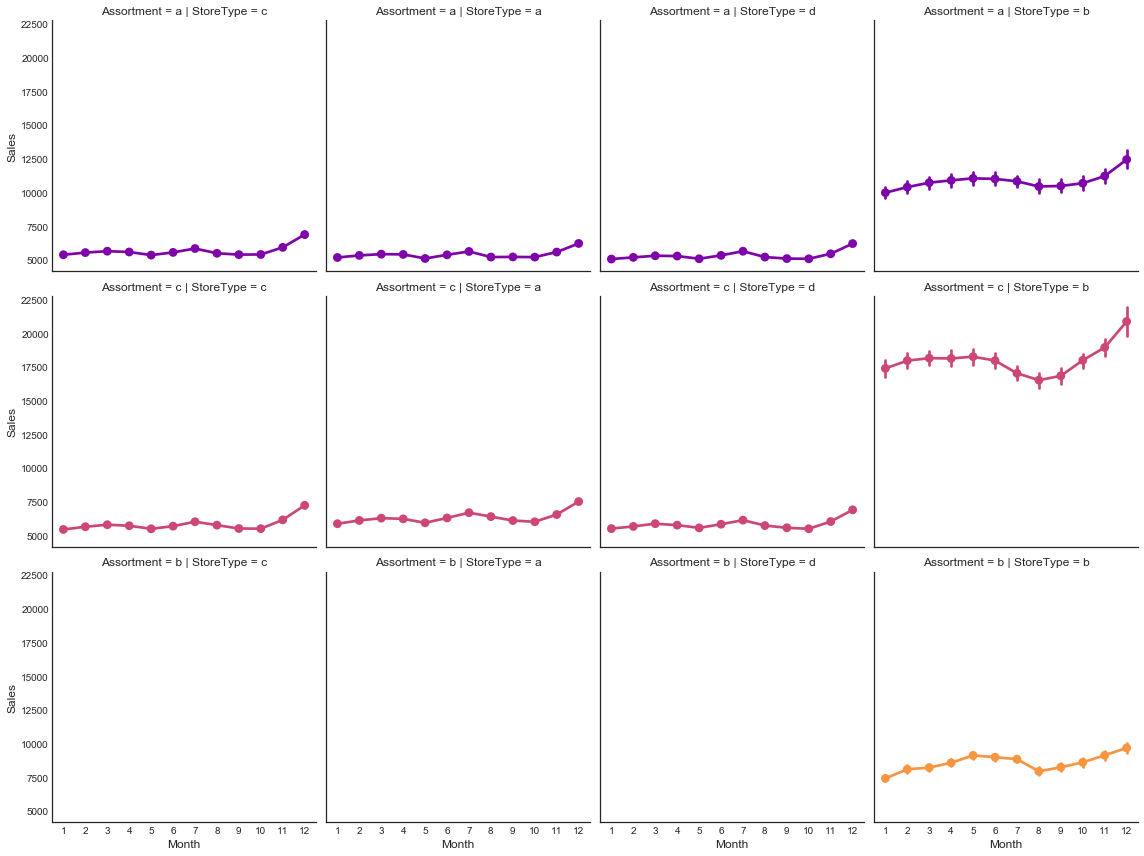

In [89]:
sns.factorplot(data = train_data, x = 'Month', y = "Sales", 
               col = 'StoreType', 
               palette = 'plasma',
               hue = 'Assortment',
               row = 'Assortment')

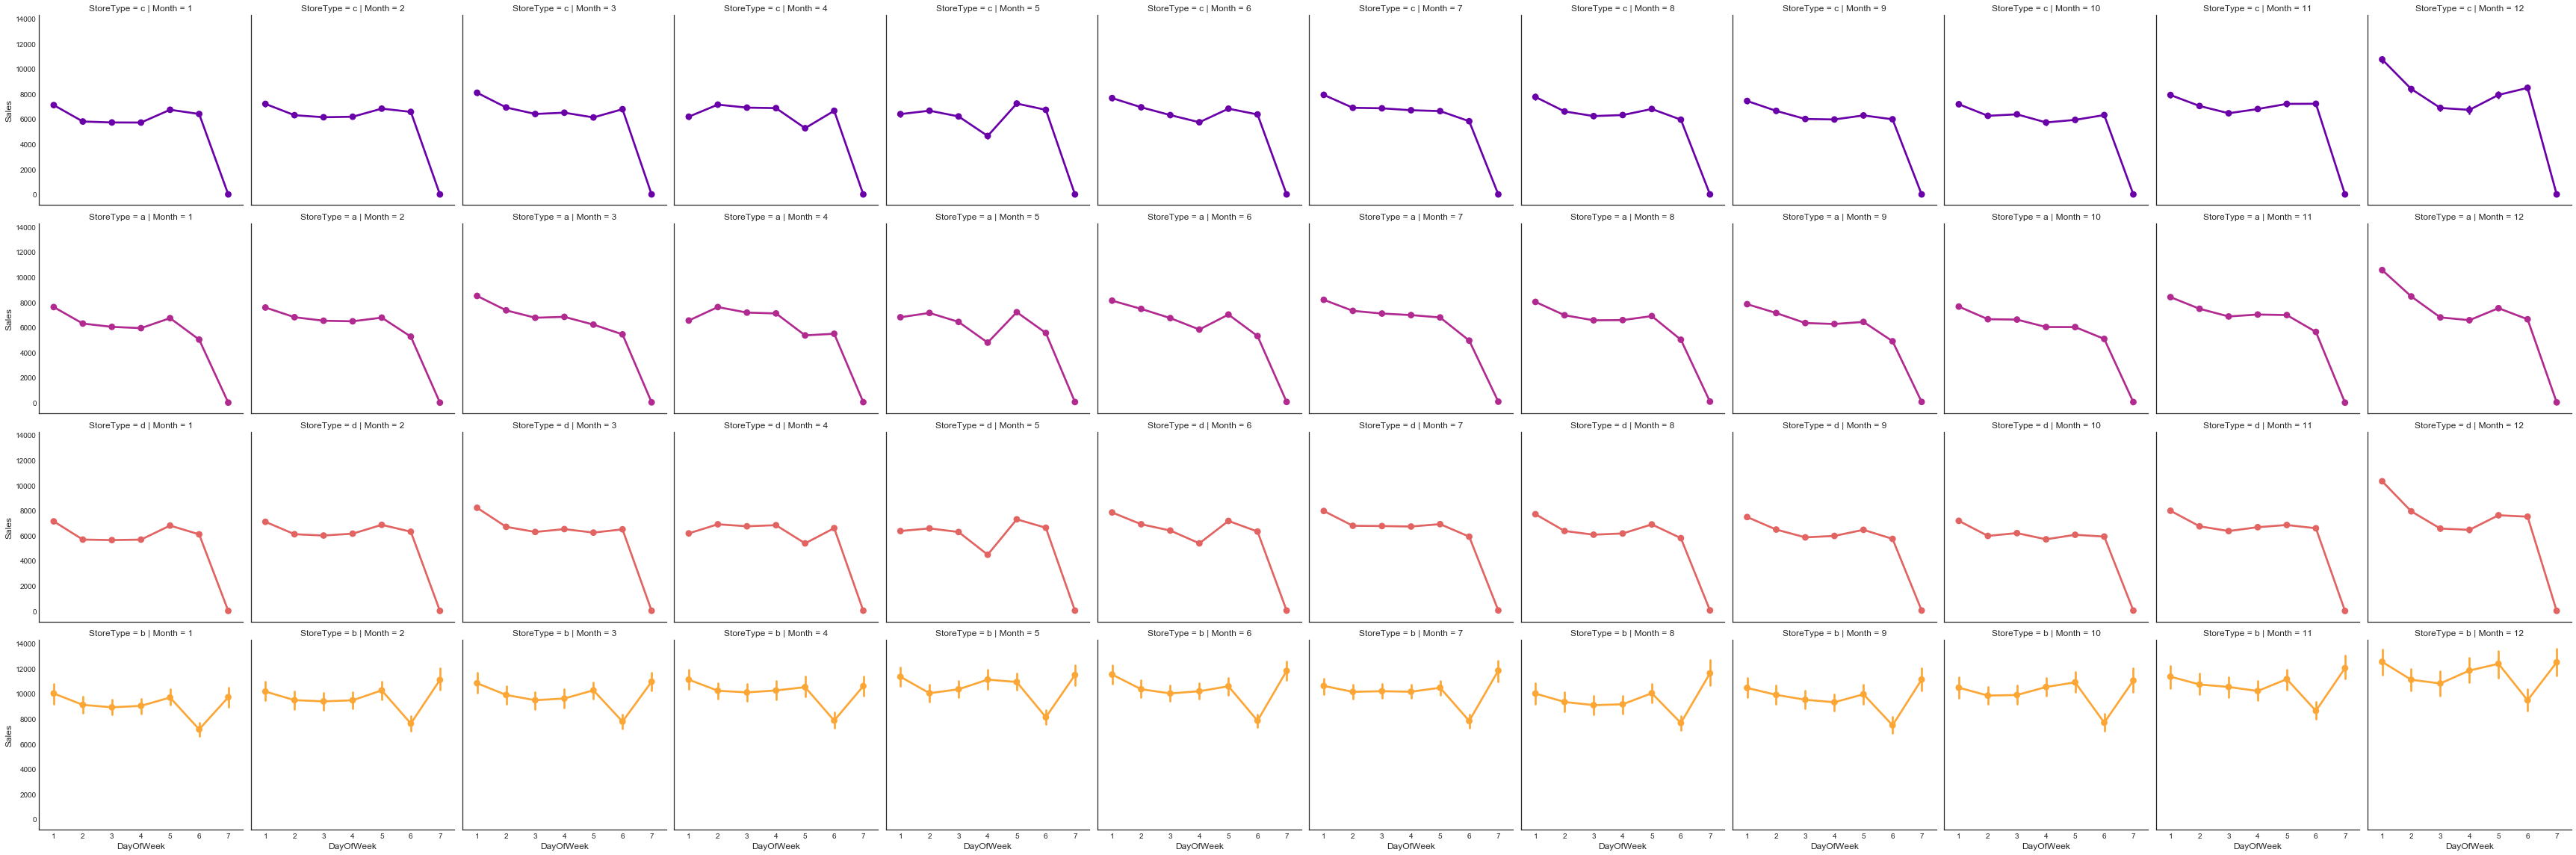

In [87]:
sns.factorplot(data = train_data, x = 'DayOfWeek', y = "Sales", 
               col = 'Month', 
               palette = 'plasma',
               hue = 'StoreType',
               row = 'StoreType')

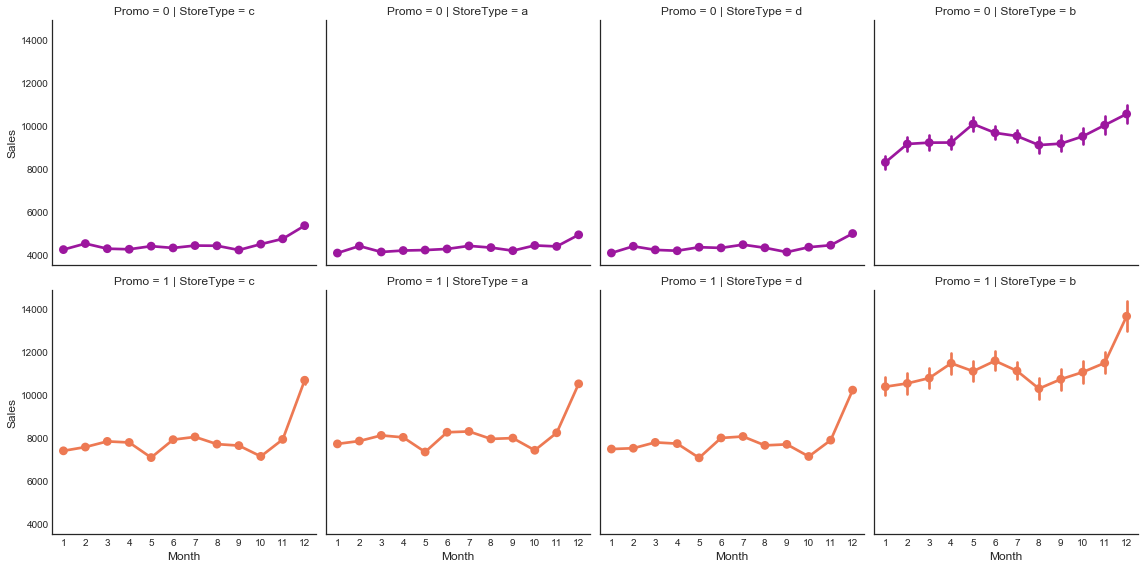

In [193]:
sns.factorplot(data = train_data, x = 'Month', y = "Sales", 
               col = 'StoreType', 
               palette = 'plasma',
               hue = 'Promo',
               row = 'Promo')

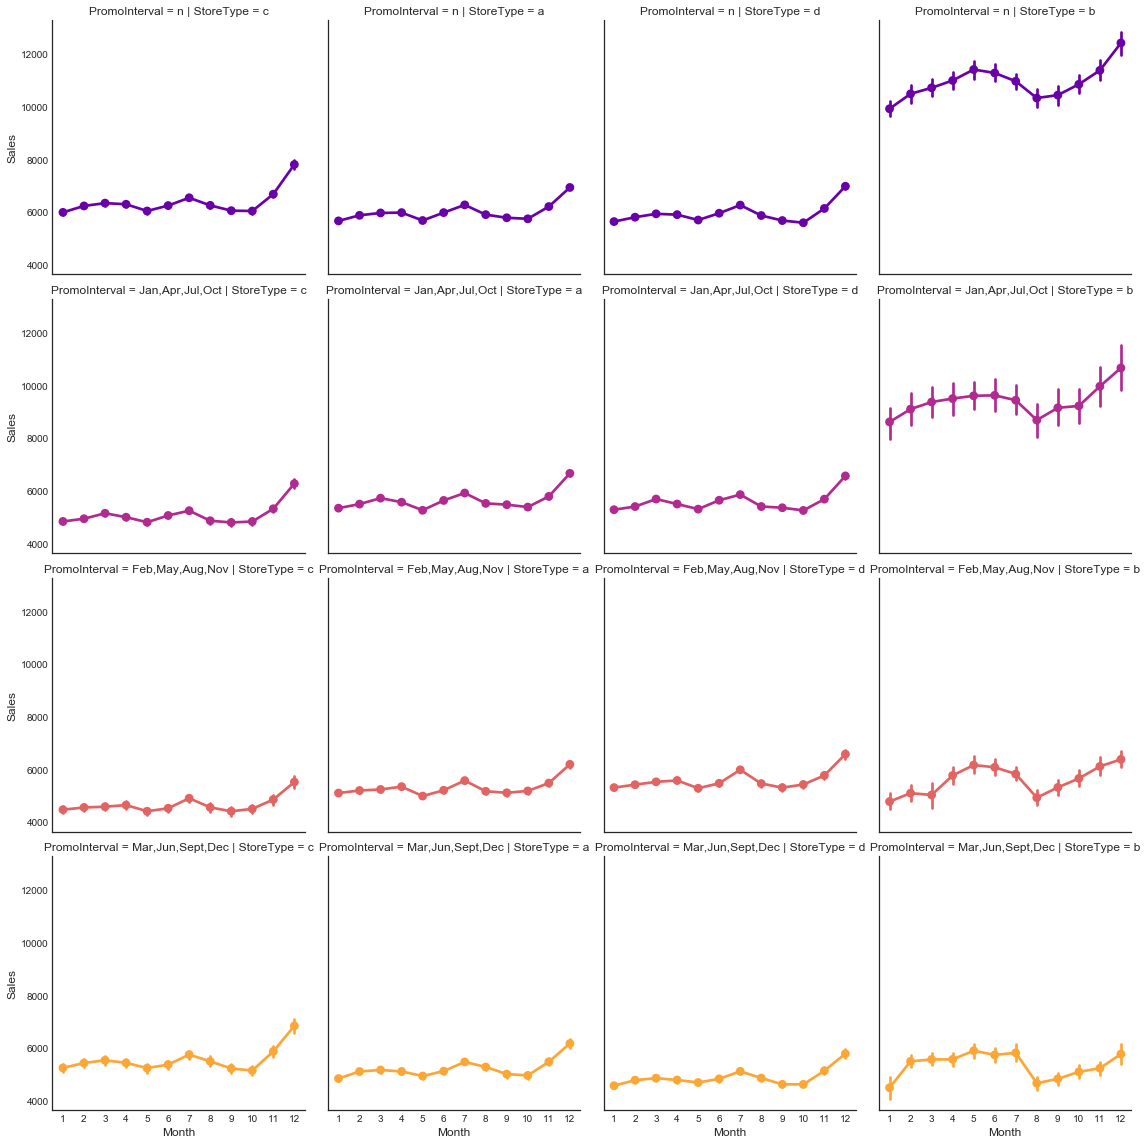

In [152]:
sns.factorplot(data = train_data, x = 'Month', y = "Sales", 
               col = 'StoreType', 
               palette = 'plasma',
               hue = 'PromoInterval',
               row = 'PromoInterval')

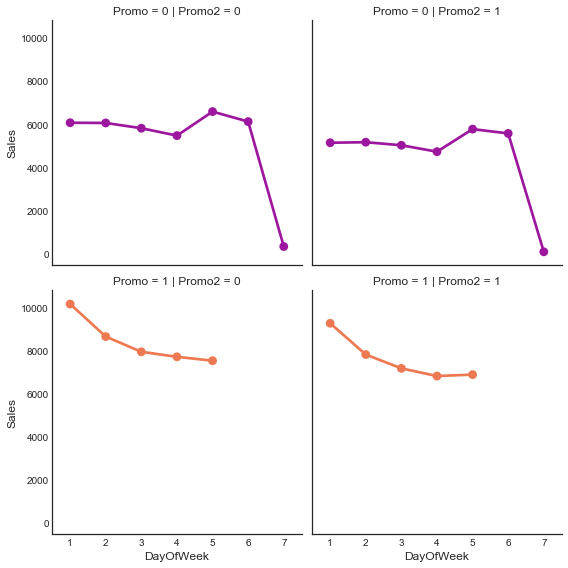

In [90]:
sns.factorplot(data = train_data, x = 'DayOfWeek', y = "Sales", 
               col = 'Promo2', 
               palette = 'plasma',
               hue = 'Promo',
               row = 'Promo')

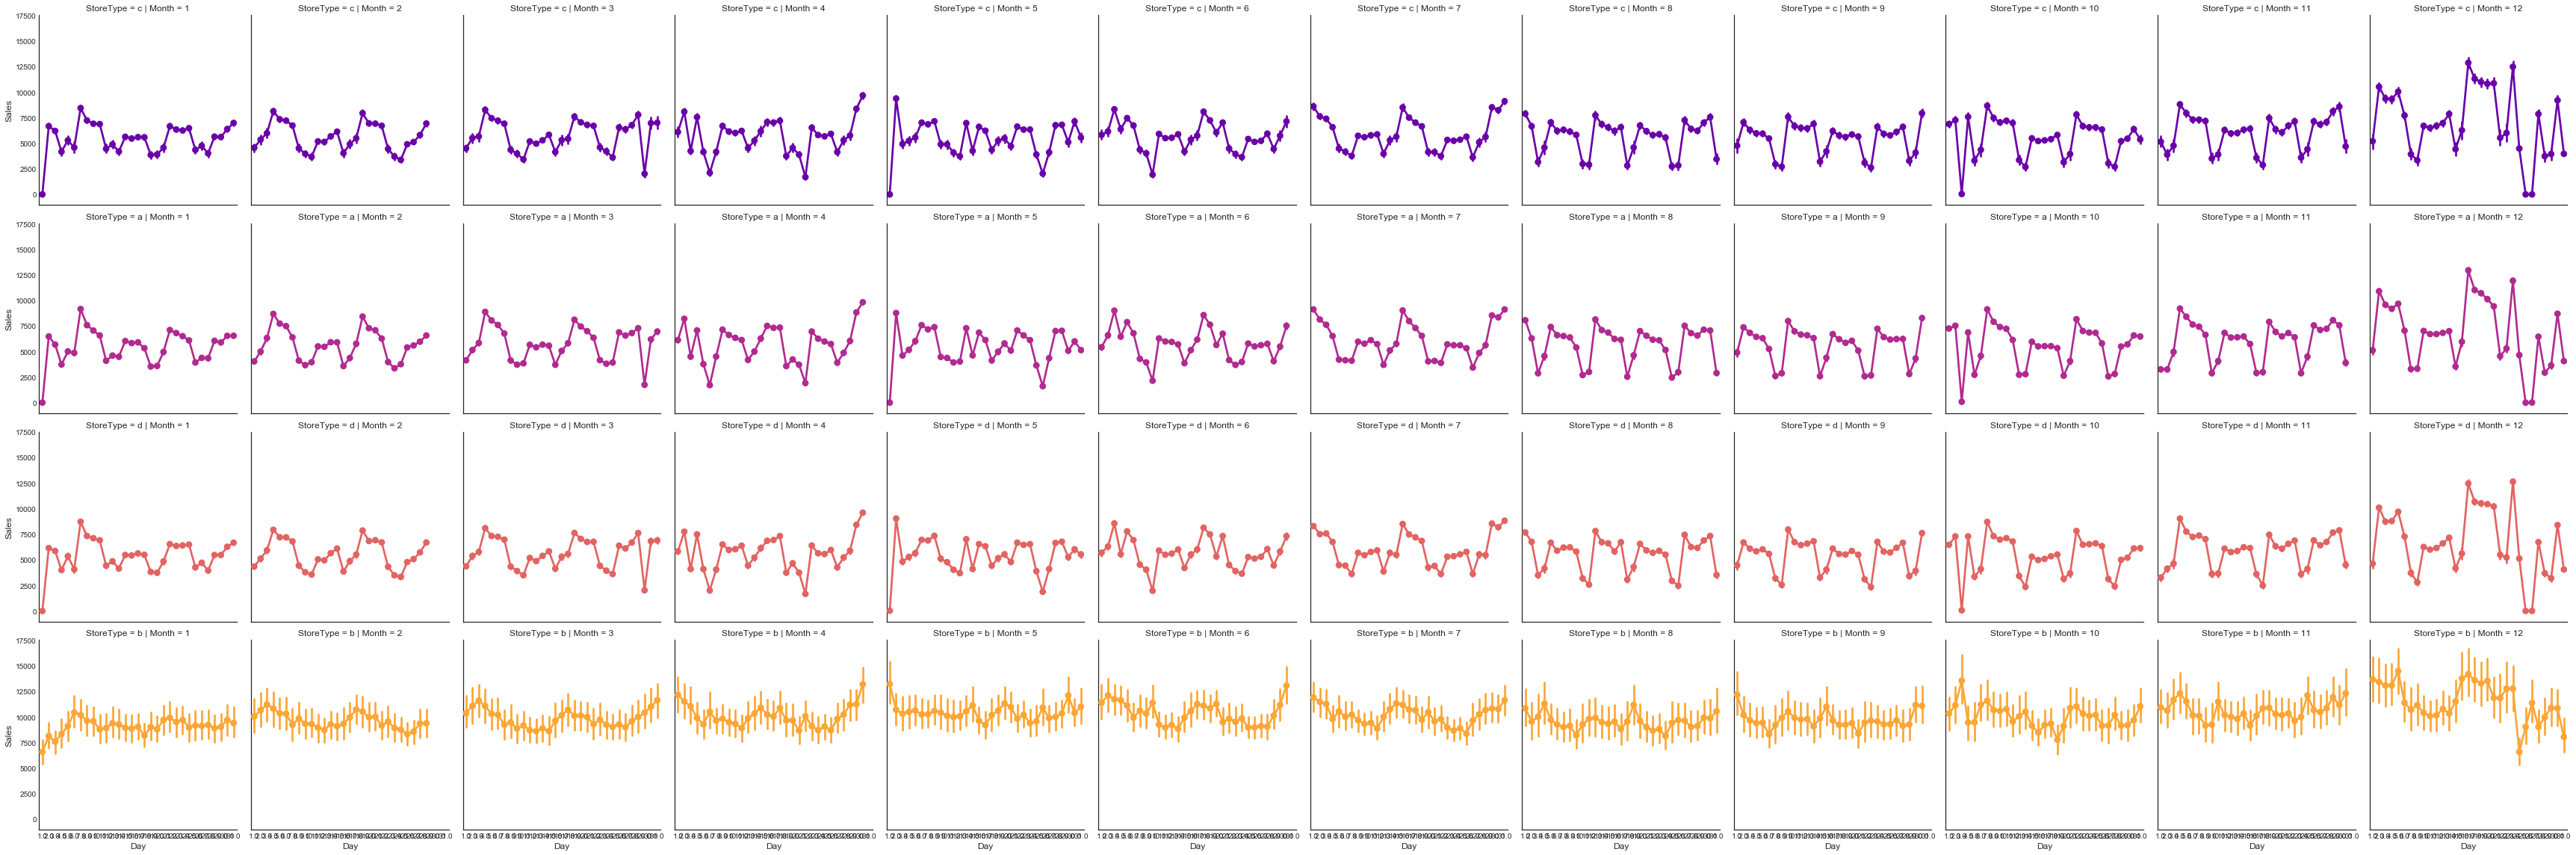

In [98]:
sns.factorplot(data = train_data, x = 'Day', y = "Sales", 
               col = 'Month', 
               palette = 'plasma',
               hue = 'StoreType',
               row = 'StoreType')

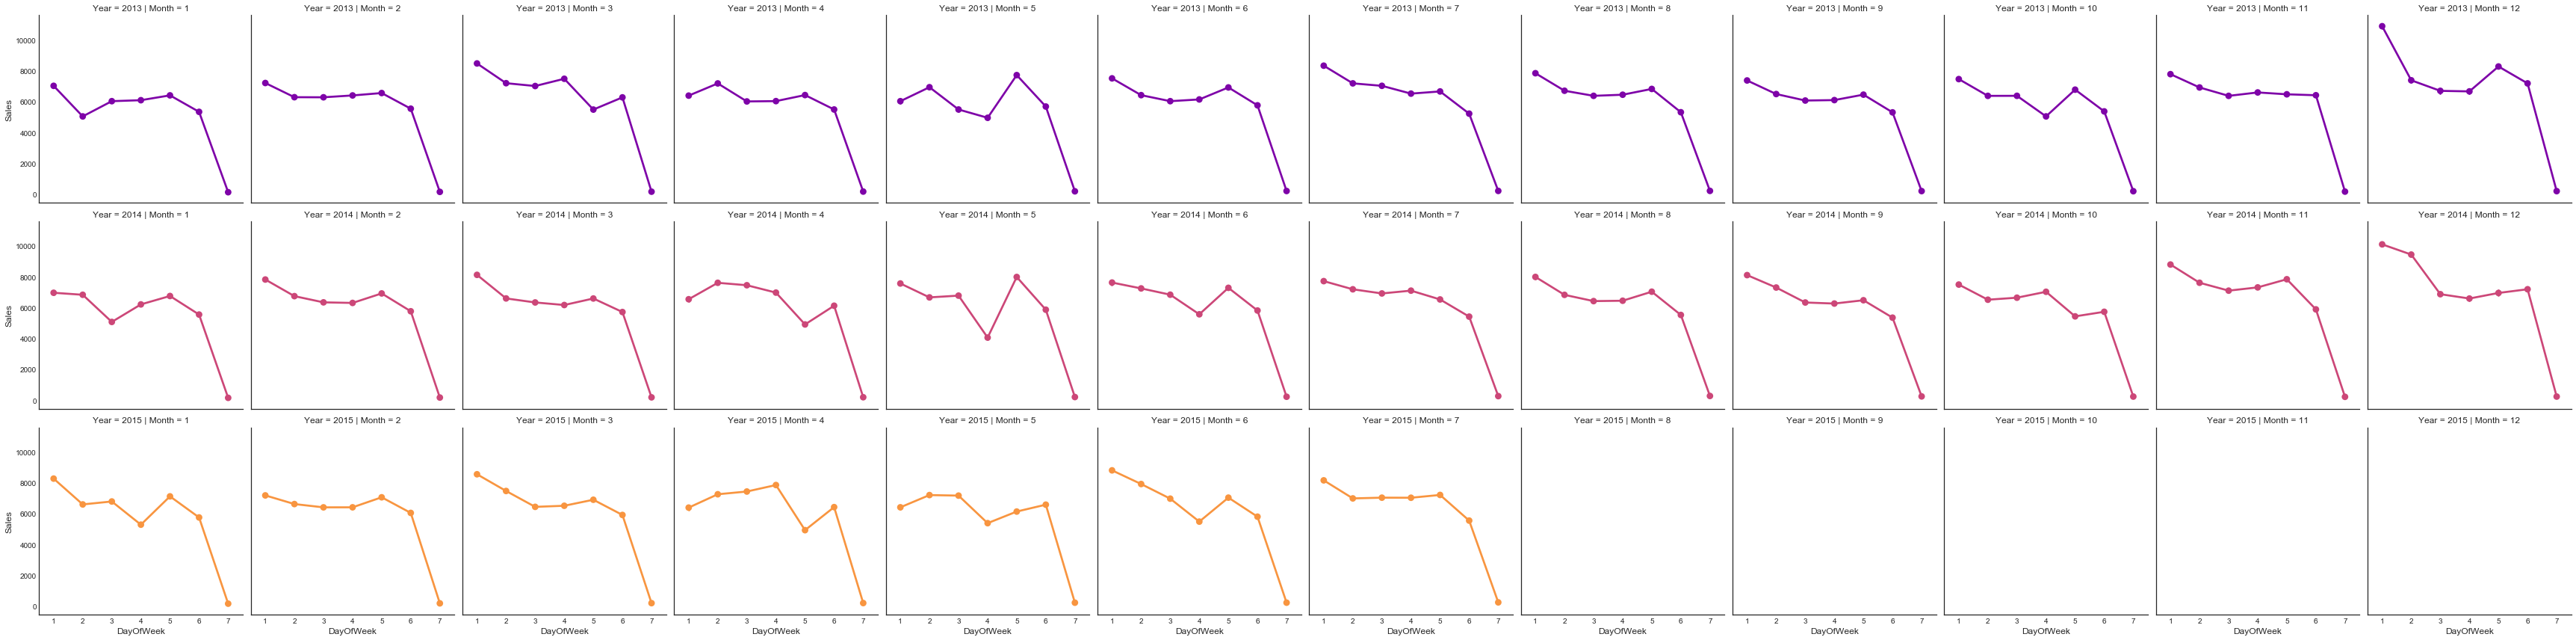

In [103]:
sns.factorplot(data = train_data, x = 'DayOfWeek', y = "Sales", 
               col = 'Month', 
               palette = 'plasma',
               hue = 'Year',
               row = 'Year')

In [159]:
#sns.distplot(train_data['CompetitionMonthDuration'])
#train_data[train_data['CompetitionMonthDuration']<0.0]
#sns.pairplot(train_data[train_data['StoreType']=='b' & train_data['CompetitionMonthDuration']>0 & train_data['Promo2WeekDuration']>0], vars=["Sales", "Customers","CompetitionMonthDuration","Promo2WeekDuration"])

#train_data['Sales_in_last_50']
#val_start_date = org_train_data.iloc[-1].Date - timedelta(weeks=6)
#mask = (org_train_data['Date'] >= val_start_date) & (org_train_data['Date'] <= org_train_data.iloc[-1].Date)

#split the training data and validation data
#val_data = org_train_data.loc[mask]

from pandas.plotting import autocorrelation_plot

#autocorrelation_plot(train_data[train_data.Store==1]['Sales'][2:4])
#plt.show()

#for i in range(1,len(store)+1):
#    train_data[train_data.Store==i]['Sales'].head(1)

17446752

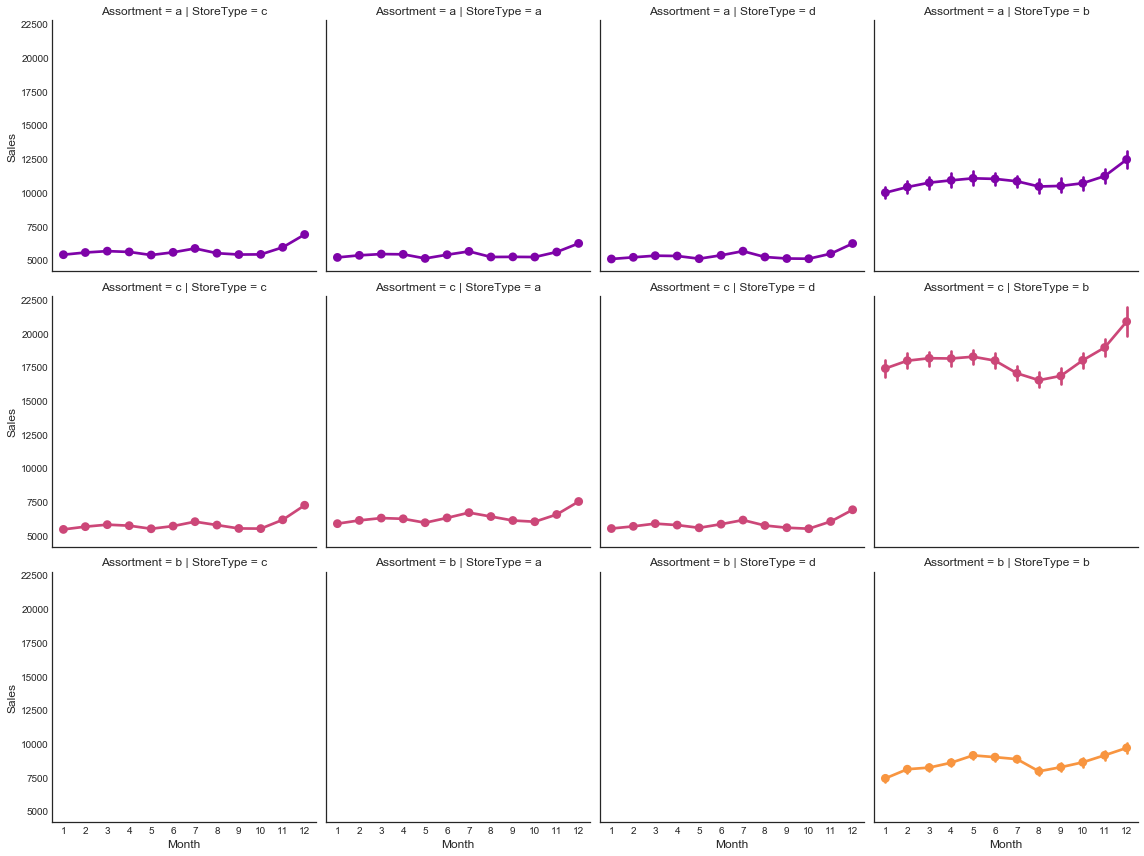

In [155]:
sns.factorplot(data = train_data, x = 'Month', y = "Sales", 
               col = 'StoreType', 
               palette = 'plasma',
               hue = 'Assortment',
               row = 'Assortment')

       Store   DayOfWeek        Sales   Customers   Open       Promo  \
count  619.0  619.000000   619.000000  619.000000  619.0  619.000000   
mean    22.0    3.515347  4525.857835  504.247173    1.0    0.441034   
std      0.0    1.720147  1140.004611   88.307597    0.0    0.496912   
min     22.0    1.000000  2479.000000  293.000000    1.0    0.000000   
25%     22.0    2.000000  3620.000000  448.000000    1.0    0.000000   
50%     22.0    3.000000  4311.000000  504.000000    1.0    0.000000   
75%     22.0    5.000000  5255.500000  563.000000    1.0    1.000000   
max     22.0    6.000000  9437.000000  989.000000    1.0    1.000000   

       SchoolHoliday  
count     619.000000  
mean        0.176090  
std         0.381205  
min         0.000000  
25%         0.000000  
50%         0.000000  
75%         0.000000  
max         1.000000  


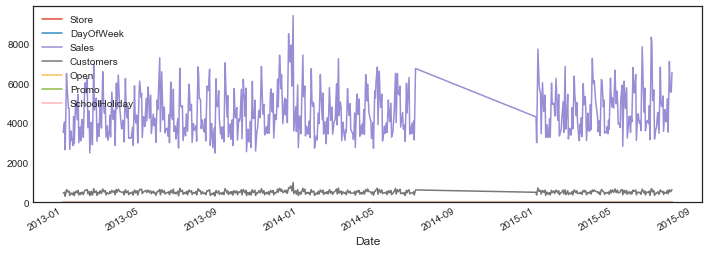

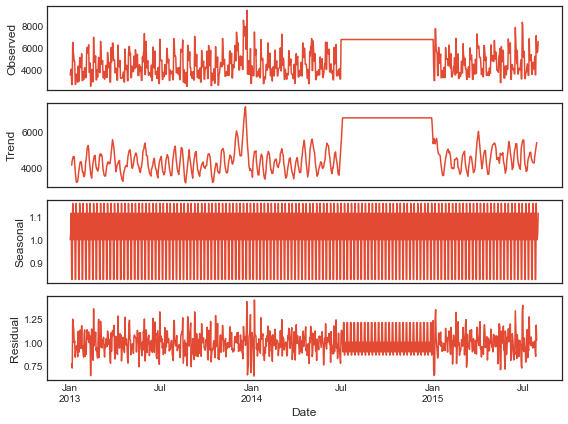

In [450]:
_,ax = plt.subplots(figsize=(20,10))
sales = train[(train['Sales']>0) & (train['Store']==22)]
print sales.describe()
sales = sales.sort_index(ascending = True)
#sales['Date'] = pd.DatetimeIndex(sales['Date'])
#sales['Date'] = pd.to_datetime(sales['Date'])
sales.plot(figsize = (12, 4),ax=ax)
ax.set_ylim(0,)
plt.show()

#sales = sales.drop(['Date'],axis=1)

sales = sales['Sales'].asfreq('d',method='pad')

from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(sales, model='multiplicative')
result.plot()
plt.show()

In [113]:
store['AssortStore'] = store['Assortment']+store['StoreType']
display(store['AssortStore'])

0       ac
1       aa
2       aa
3       cc
4       aa
5       aa
6       ca
7       aa
8       ca
9       aa
10      ca
11      ca
12      ad
13      aa
14      cd
15      ca
16      aa
17      cd
18      ca
19      ad
20      cc
21      aa
22      ad
23      ca
24      ac
25      ad
26      aa
27      aa
28      cd
29      aa
        ..
1085    aa
1086    cd
1087    aa
1088    ad
1089    aa
1090    ca
1091    aa
1092    cc
1093    ad
1094    aa
1095    ca
1096    bb
1097    aa
1098    ca
1099    aa
1100    cd
1101    aa
1102    cd
1103    ad
1104    cc
1105    ca
1106    aa
1107    aa
1108    ac
1109    cc
1110    aa
1111    cc
1112    ca
1113    ca
1114    cd
Name: AssortStore, Length: 1115, dtype: object

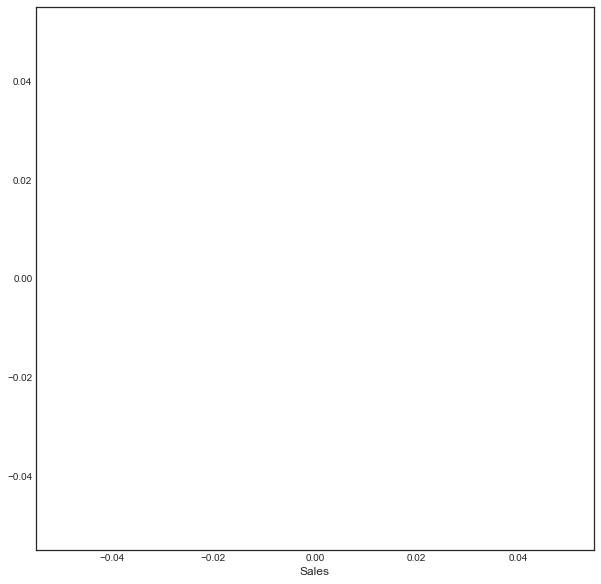

In [97]:
_,ax = plt.subplots(figsize=(10,10))
sns.distplot(np.log1p(sales['Sales']),ax=ax)

In [4]:
def build_features(features):
    features['Promo2SinceWeek'].fillna(0,inplace=True)
    features['Promo2SinceYear'].fillna(0,inplace=True)
    features['PromoInterval'].fillna('n',inplace=True)
    features['CompetitionOpenSinceMonth'].fillna(0,inplace=True)
    features['CompetitionOpenSinceYear'].fillna(0,inplace=True)
    features['StateHoliday'] = features['StateHoliday'].replace('a',1)
    features['StateHoliday'] = features['StateHoliday'].replace('b',2)
    features['StateHoliday'] = features['StateHoliday'].replace('c',3)
    features['StateHoliday'] = pd.to_numeric(features['StateHoliday'], downcast='integer')
    features['isStateHoliday'] =  features['StateHoliday'].map(lambda x: 0 if x==0 else 1)
    features = pd.get_dummies(features,columns=['DayOfWeek','StoreType','Assortment','PromoInterval'])
    features['StoreType_b'] = features['StoreType_b'].map(lambda x: x*3)
    
    features['Date'] = pd.to_datetime(features['Date'])
    features['Month'] = features['Date'].map(lambda x: x.month)
    features['Year'] = features['Date'].map(lambda x: x.year)
    features['Week'] = features['Date'].map(lambda x: x.strftime("%V"))
    features['Week']= pd.to_numeric(features['Week'], downcast='integer')
    features['Season'] = features['Date'].map(lambda x: 1 if x.month in [1,2,3] else (2 if x.month in [4,5,6] else (3 if x.month in [7,8,9] else 4)))
    
    features["CompetitionDistance"].fillna(0,inplace=True)
    features["CompetitionDistance"] = np.log1p(features["CompetitionDistance"])
    features["CompetitionMonthDuration"] = (features['Month']-features['CompetitionOpenSinceMonth'])+(features['Year']-features['CompetitionOpenSinceYear'])*12
    features["Promo2WeekDuration"] = (features['Week']-features['Promo2SinceWeek'])/4+(features['Year']-features['Promo2SinceYear'])*12
    features["CompetitionMonthDuration"].fillna(0,inplace=True)
    features["Promo2WeekDuration"].fillna(0,inplace=True)
    features["CompetitionMonthDuration"] = np.log1p(features["CompetitionMonthDuration"])
    features["Promo2WeekDuration"] = np.log1p(features["Promo2WeekDuration"])
    
    features['AllPromo'] = features.apply(lambda x: 1 if x['Promo']&x['Promo2'] else 0,axis=1)
    features['NoPromo'] = features.apply(lambda x: 1 if ~x['Promo']&~x['Promo2'] else 0,axis=1)
    
    features = features.drop(['Date','Store'],axis=1)
    if 'Customers' in features.columns:
        features = features.drop(['Customers'],axis=1)
    features.fillna(0,inplace=True)
    
    return features

In [5]:
org_train_data = pd.merge(train,store,on='Store')
#org_train_data['Date'] = pd.to_datetime(org_train_data['Date'])
org_train_data.set_index(['Date','Store'],inplace=True,drop=False)
org_train_data.sort_index(inplace=True)

org_test_data = pd.merge(test,store,on='Store')
#org_test_data['Date'] = pd.to_datetime(org_test_data['Date'])
org_test_data.set_index(['Date','Store'],inplace=True,drop=False)
org_test_data.sort_index(inplace=True)

combine_data = org_train_data.copy()
combine_data = org_train_data.append(org_test_data)

new_combine_data = pd.DataFrame([])

for i in range(1,len(store)+1):
    temp_data = combine_data[combine_data.Store==i].copy()
    # lags of series
    for j in range(49, 61):
        temp_data["lag_{}".format(j)] = combine_data[combine_data.Store==i]['Sales'].shift(j)
    for j in range(49, 61):
        temp_data['lag_{}_customers'.format(j)] = combine_data[combine_data.Store==i]['Customers'].shift(j)
    for j in range(49, 61):
        temp_data["ma_{}_mean".format(j)] = combine_data[combine_data.Store==i]['Sales'].shift(j).rolling(7).mean()
    new_combine_data = pd.concat([new_combine_data,temp_data],axis=0)

In [6]:
display((new_combine_data))

,,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Customers,Date,DayOfWeek,Id,Open,Promo,...,ma_51_mean,ma_52_mean,ma_53_mean,ma_54_mean,ma_55_mean,ma_56_mean,ma_57_mean,ma_58_mean,ma_59_mean,ma_60_mean
Date,Store,,,,,,,,,,,,,,,,,,,,,
2013-01-01,1,a,1270.0,9.0,2008.0,0.0,2013-01-01,2,NaN,0.0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-01-02,1,a,1270.0,9.0,2008.0,668.0,2013-01-02,3,NaN,1.0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-01-03,1,a,1270.0,9.0,2008.0,578.0,2013-01-03,4,NaN,1.0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-01-04,1,a,1270.0,9.0,2008.0,619.0,2013-01-04,5,NaN,1.0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-01-05,1,a,1270.0,9.0,2008.0,635.0,2013-01-05,6,NaN,1.0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-01-06,1,a,1270.0,9.0,2008.0,0.0,2013-01-06,7,NaN,0.0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-01-07,1,a,1270.0,9.0,2008.0,785.0,2013-01-07,1,NaN,1.0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-01-08,1,a,1270.0,9.0,2008.0,654.0,2013-01-08,2,NaN,1.0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-01-09,1,a,1270.0,9.0,2008.0,626.0,2013-01-09,3,NaN,1.0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
new_combine_data['Id'] = pd.to_numeric(new_combine_data['Id'],downcast='integer')

for i in range(49, 61):
    lagname = "lag_{}".format(i)
    new_combine_data = new_combine_data[new_combine_data[lagname].notnull()]
    
from datetime import datetime
test_start_date = '2015-08-01'
test_start_date = datetime.strptime(test_start_date,'%Y-%m-%d')

org_train_data = new_combine_data[new_combine_data.Date<test_start_date].drop(['Id'],axis=1)
org_test_data = new_combine_data[new_combine_data.Date>=test_start_date]


In [8]:
val_start_date = org_train_data.iloc[-1].Date - timedelta(weeks=6)
mask = (org_train_data['Date'] >= val_start_date) & (org_train_data['Date'] <= org_train_data.iloc[-1].Date)

#split the training data and validation data
val_data = org_train_data.loc[mask]
train_data = org_train_data.loc[~mask]


features_train = train_data[train_data['Sales']!=0].drop('Sales',axis=1)
sales_train = np.log1p(train_data[train_data['Sales']!=0]['Sales'])

features_val = val_data[val_data['Sales']!=0].drop('Sales',axis=1)
sales_val = np.log1p(val_data[val_data['Sales']!=0]['Sales'])

features_train = build_features(features_train)
features_val = build_features(features_val)

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
#features_train_scaled = scaler.fit_transform(features_train)
#features_val_scaled = scaler.fit_transform(features_val)

# 将'features'和'val'数据切分成训练集和测试集
#X_train, X_val, y_train, y_val = train_test_split(features_train, sales_train, test_size = 0.1,random_state = 42)

#xgdmat=xgb.DMatrix(features_train,sales_train)
params = {"objective": "reg:linear",
          "booster" : "gbtree",
          "eta": 0.2,
          "max_depth": 12,
          "subsample": 0.9,
          "colsample_bytree": 0.5,
          "silent": 1
          }
num_trees = 50

from xgboost import XGBRegressor 
xgb = XGBRegressor()
xgb.fit(features_train, sales_train)

#final_gb=xgb.train(params,xgdmat,num_trees,feval=rmspe_score)
#tesdmat=xgb.DMatrix(features_val)
y_pred=xgb.predict(features_val)

print rmspe_score(sales_val,y_pred)

#reg = LinearRegression()
#reg.fit(X_train,y_train)
#y_pred=reg.predict(X_val)

#print rmspe_score(y_val,y_pred)
#print reg.score(X_val,y_val)

('RMSPE', 0.01818273166441248)


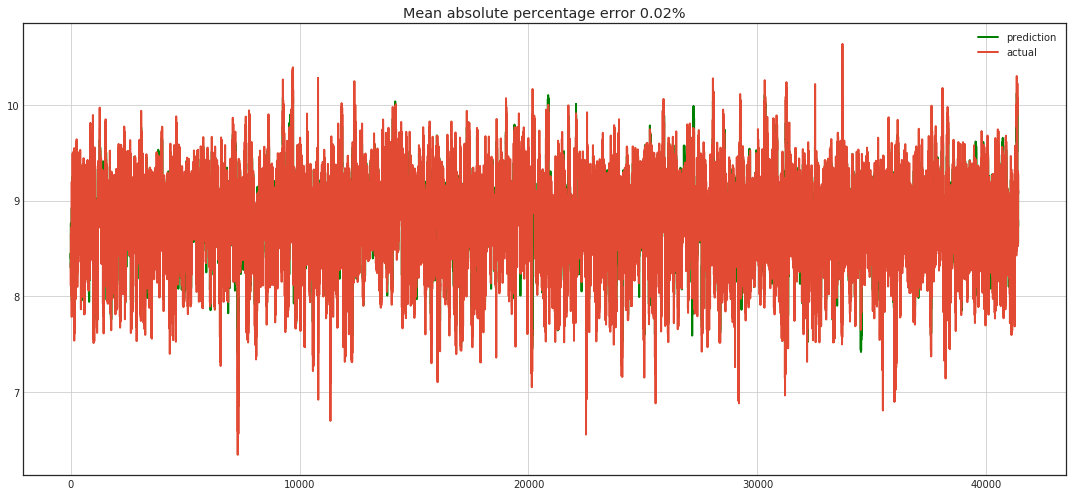

In [9]:
plotModelResults(xgb, 
                 X_train=features_train, 
                 X_test=features_val,
                 y_test=sales_val)

In [10]:
org_test_data['Date'] = pd.to_datetime(org_test_data['Date'])
org_test_data.set_index(['Date','Store'],inplace=True,drop=False)
org_test_data.sort_index(inplace=True)
test = build_features(org_test_data)
not_open_index = test[test['Open']==0].index
test_train = test.drop(['Id'],axis=1)
test_result = xgb.predict(test_train)
submission = pd.DataFrame({"Id": test['Id'], "Sales": np.expm1(test_result)})
submission.set_value(not_open_index,"Sales",0.0)
#submission.ix[not_open_index]["Sales"] = 0.0
submission['Id'] = pd.to_numeric(submission['Id'], downcast='integer')
display(submission.ix[not_open_index])
submission.to_csv("my_submission.csv", index=False)

Id  Sales
Date       Store              
2015-08-02 1      39377    0.0
           3      39378    0.0
           7      39379    0.0
           8      39380    0.0
           9      39381    0.0
           10     39382    0.0
           11     39383    0.0
           12     39384    0.0
           13     39385    0.0
           14     39386    0.0
           15     39387    0.0
           16     39388    0.0
           19     39389    0.0
           20     39390    0.0
           21     39391    0.0
           22     39392    0.0
           23     39393    0.0
           24     39394    0.0
           25     39395    0.0
           27     39396    0.0
           29     39397    0.0
           30     39398    0.0
           31     39399    0.0
           32     39400    0.0
           33     39401    0.0
           35     39402    0.0
           36     39403    0.0
           38     39404    0.0
           39     39405    0.0
           40     39406    0.0
...                 ...    ...
2015-09-13 1100    4267    0.0
           1101    4268    0.0
           1102    4269    0.0
           1103    4270    0.0
           1104    4271    0.0
           1105    4272    0.0
           1106    4273    0.0
           1107    4274    0.0
           1109    4275    0.0
           1111    4276    0.0
           1112    4277    0.0
           1113    4278    0.0
           1114    4279    0.0
           1115    4280    0.0
2015-09-14 622     3048    0.0
           703     3112    0.0
           879     3245    0.0
           1097    3409    0.0
2015-09-15 622     2192    0.0
           703     2256    0.0
           879     2389    0.0
           1097    2553    0.0
2015-09-16 622     1336    0.0
           703     1400    0.0
           879     1533    0.0
           1097    1697    0.0
2015-09-17 622      480    0.0
           703      544    0.0
           879      677    0.0
           1097     841    0.0

[5995 rows x 2 columns]

In [ ]:
# XGB feature importances
# Based on https://www.kaggle.com/mmueller/liberty-mutual-group-property-inspection-prediction/xgb-feature-importance-python/code
import operator

create_feature_map(features_train)
importance = final_gb.get_fscore(fmap='xgb.fmap')
importance = sorted(importance.items(), key=operator.itemgetter(1))

df = pd.DataFrame(importance, columns=['feature', 'fscore'])
df['fscore'] = df['fscore'] / df['fscore'].sum()

featp = df.plot(kind='barh', x='feature', y='fscore', legend=False, figsize=(6, 10))
plt.title('XGBoost Feature Importance')
plt.xlabel('relative importance')
fig_featp = featp.get_figure()
fig_featp.savefig('feature_importance_xgb.png', bbox_inches='tight', pad_inches=1)

In [102]:
#Load the data from csv
store = pd.read_csv('./input/store.csv')
train = pd.read_csv('./input/train.csv', parse_dates=["Date"],keep_date_col=True)
test = pd.read_csv('./input/test.csv', parse_dates=["Date"],keep_date_col=True)

#Data information Analysis including the data type and how many observations etc.
display(store.info())
display(train.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1115 entries, 0 to 1114
Data columns (total 10 columns):
Store                        1115 non-null int64
StoreType                    1115 non-null object
Assortment                   1115 non-null object
CompetitionDistance          1112 non-null float64
CompetitionOpenSinceMonth    761 non-null float64
CompetitionOpenSinceYear     761 non-null float64
Promo2                       1115 non-null int64
Promo2SinceWeek              571 non-null float64
Promo2SinceYear              571 non-null float64
PromoInterval                571 non-null object
dtypes: float64(5), int64(2), object(3)
memory usage: 87.2+ KB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 9 columns):
Store            1017209 non-null int64
DayOfWeek        1017209 non-null int64
Date             1017209 non-null datetime64[ns]
Sales            1017209 non-null int64
Customers        1017209 non-null int64
Open             1017209 non-null int64
Promo            1017209 non-null int64
StateHoliday     1017209 non-null object
SchoolHoliday    1017209 non-null int64
dtypes: datetime64[ns](1), int64(7), object(1)
memory usage: 69.8+ MB


None

In [13]:
warnings.filterwarnings('ignore')
#Load the data from csv
store = pd.read_csv('./input/store.csv')
train = pd.read_csv('./input/train.csv', parse_dates=["Date"],keep_date_col=True)
test = pd.read_csv('./input/test.csv', parse_dates=["Date"],keep_date_col=True)

#Data information Analysis including the data type and how many observations etc.
display(store.info())
display(train.info())

def build_features(features):
    #features['Promo2SinceWeek'].fillna(0,inplace=True)
    #features['Promo2SinceYear'].fillna(0,inplace=True)
    features['PromoInterval'].fillna('n',inplace=True)
    #features['CompetitionOpenSinceMonth'].fillna(0,inplace=True)
    #features['CompetitionOpenSinceYear'].fillna(0,inplace=True)
    features['StateHoliday'] = features['StateHoliday'].replace('a',1)
    features['StateHoliday'] = features['StateHoliday'].replace('b',2)
    features['StateHoliday'] = features['StateHoliday'].replace('c',3)
    features['StateHoliday'] = features['StateHoliday'].astype(float)
    features['StoreType'] = features['StoreType'].replace('a',1)
    features['StoreType'] = features['StoreType'].replace('b',2)
    features['StoreType'] = features['StoreType'].replace('c',3)
    features['StoreType'] = features['StoreType'].replace('d',4)
    features['StoreType'] = features['StoreType'].astype(float)
    features['Assortment'] = features['Assortment'].replace('a',1)
    features['Assortment'] = features['Assortment'].replace('b',2)
    features['Assortment'] = features['Assortment'].replace('c',3)
    features['Assortment'] = features['Assortment'].astype(float)
    #features['isStateHoliday'] =  features['StateHoliday'].map(lambda x: 0 if x==0 else 1)
    #features = pd.get_dummies(features,columns=['DayOfWeek','StoreType','Assortment','PromoInterval'])
    AssortStore = {'aa':1,'ab':2,'ac':3,'ad':4,'ba':5,'bb':6,'bc':7,'bd':8,'ca':9,'cb':10,'cc':11,'cd':12}
    features['AssortStore'] = features['Assortment']+features['StoreType']
    features['AssortStore'] = features['AssortStore'].map(AssortStore)
    features['Date'] = pd.to_datetime(features['Date'])
    
    features['DayOfWeekPlusState'] = features['DayOfWeek'].astype(float)+features['StateHoliday']
    features['DayOfWeekPlusSchool'] = features['DayOfWeek'].astype(float)+features['SchoolHoliday']
    #features['DayOfWeekPlusSuperHoliday'] = features['DayOfWeek'].astype(float)+features['SchoolHoliday']+features['StateHoliday']
    features['DayOfPromo'] = features['DayOfWeek'].astype(float)+(features['Promo'].astype(float)/2.0)
    features['WeekOfYear'] = features['Date'].map(lambda x: x.isocalendar()[1]).astype(float)
    features['DayOfYear'] = features['Date'].map(lambda x: x.timetuple().tm_yday).astype(float)
    features['Day']=features['Date'].map(lambda x:x.day).astype(float)
    features['Month'] = features['Date'].map(lambda x: x.month).astype(float)
    features['Year'] = features['Date'].map(lambda x: x.year).astype(float)
    features['Season'] = features['Date'].map(lambda x: 1 if x.month in [1,2,3] else (2 if x.month in [4,5,6] else (3 if x.month in [7,8,9] else 4))).astype(float)
    month2str = {1:'Jan', 2:'Feb', 3:'Mar', 4:'Apr', 5:'May', 6:'Jun', \
             7:'Jul', 8:'Aug', 9:'Sept', 10:'Oct', 11:'Nov', 12:'Dec'}
    features['monthStr'] = features.Month.map(month2str)
    features.loc[features.PromoInterval == 0, 'PromoInterval'] = ''
    features['IsPromoMonth'] = 0
    for interval in features.PromoInterval.unique():
        if interval != '':
            for month in interval.split(','):
                features.loc[(features.monthStr == month) & (features.PromoInterval == interval), 'IsPromoMonth'] = 1.0
    
    features["CompetitionDistance"].fillna(0,inplace=True)
    features["CompetitionDistance"] = np.log(features["CompetitionDistance"]+1)
    features["CompetitionMonthDuration"] = (features['Month']-features['CompetitionOpenSinceMonth'])+(features['Year']-features['CompetitionOpenSinceYear'])*12
    features["Promo2WeekDuration"] = (features['WeekOfYear']-features['Promo2SinceWeek'])/4+(features['Year']-features['Promo2SinceYear'])*12
    features['Promo2WeekDuration'] = features.Promo2WeekDuration.apply(lambda x: x if x > 0 else 0)
    features.loc[features.Promo2SinceYear == 0, 'Promo2WeekDuration'] = 0
    
    features["CompetitionMonthDuration"].fillna(0,inplace=True)
    
    features["Promo2WeekDuration"].fillna(0,inplace=True)
    features["CompetitionMonthDuration"] = (features["CompetitionMonthDuration"]+1)
    features["Promo2WeekDuration"] = (features["Promo2WeekDuration"]+1)
    PromoCombo = {'11':1,'10':2,'01':3,'00':4}
    features['PromoCombo'] = features['Promo'].astype(str)+features['Promo2'].astype(str)
    features['PromoCombo'] = features['PromoCombo'].map(PromoCombo)
    #features['AllPromo'] = features.apply(lambda x: 1 if x['Promo']&x['Promo2'] else 0,axis=1)
    
    features = features.drop(['Date','PromoInterval','Promo2SinceWeek','Promo2SinceYear','CompetitionOpenSinceYear','CompetitionOpenSinceMonth','monthStr'],axis=1)
    if 'Customers' in features.columns:
        features = features.drop(['Customers'],axis=1)
    features.fillna(0,inplace=True)
    
    return features

#Record Feature Building Time
feature_building_start = time.time()

store['SalesPerStore'] = np.zeros(store.Store.shape)
for i in range(1,len(store)+1):
    avg = (train[train.Store==i][train.Sales>0]['Sales']/train[train.Store==i][train.Sales>0]['Customers']).mean()
    store.set_value(store.Store==i,"SalesPerStore",avg)

org_train_data = pd.merge(train,store,on='Store')
#org_train_data['Date'] = pd.to_datetime(org_train_data['Date'])
org_train_data.set_index(['Date','Store'],inplace=True,drop=False)
org_train_data.sort_index(inplace=True)

org_test_data = pd.merge(test,store,on='Store')
#org_test_data['Date'] = pd.to_datetime(org_test_data['Date'])
org_test_data.set_index(['Date','Store'],inplace=True,drop=False)
org_test_data.sort_index(inplace=True)


    
combine_data = org_train_data.copy()
combine_data = org_train_data.append(org_test_data)

combine_data = combine_data.copy()


new_combine_data = pd.DataFrame([])
min_start = 43
max_end = 44


small_sample = range(1,len(store)+1,5)

for i in small_sample:
    temp_data = combine_data[combine_data.Store==i].copy()
    # lags of series
    #temp_data['yesterday_is_schoolholiday'] = combine_data[combine_data.Store==i]['SchoolHoliday'].shift(1)
    #temp_data['yesterday_is_promo'] = combine_data[combine_data.Store==i]['Promo'].shift(1)
    new_combine_data = pd.concat([new_combine_data,temp_data],axis=0) 
'''
    temp_data['yesterday_is_schoolholiday'] = combine_data[combine_data.Store==i]['SchoolHoliday'].shift(1)
    temp_data['yesterday_is_promo'] = combine_data[combine_data.Store==i]['Promo'].shift(1)
    window = 7
    for j in range(min_start,max_end,1):
        temp_data["lag_{}".format(j)] = (combine_data[combine_data.Store==i]['Sales'].shift(j))
    
    temp_data['yesterday_is_schoolholiday'] = combine_data[combine_data.Store==i]['SchoolHoliday'].shift(1)
    temp_data['yesterday_is_promo'] = combine_data[combine_data.Store==i]['Promo'].shift(1)

    for j in range(min_start,max_end,1):
        temp_data["ma_{}_mean".format(j)] = (combine_data[combine_data.Store==i]['Sales'].shift(j).rolling(window).mean())
    for j in range(min_start,max_end,1):
        temp_data['lag_{}_customers'.format(j)] = (combine_data[combine_data.Store==i]['Customers'].shift(j))
    for j in range(min_start,max_end,1):
        temp_data["ma_{}_median".format(j)] = (combine_data[combine_data.Store==i]['Sales'].shift(j).rolling(window).median())
    for j in range(min_start,max_end,1):
        temp_data["ma_{}_Open".format(j)] = (combine_data[combine_data.Store==i]['Open'].shift(j).rolling(window).mean())
    for j in range(43,45,1):
        temp_data["ma_{}_SchoolHoliday_mean".format(j)] = (combine_data[combine_data.Store==i]['SchoolHoliday'].shift(j).rolling(window).mean())
    for j in range(43,45,1):
        temp_data["ma_{}_Open".format(j)] = (combine_data[combine_data.Store==i]['Open'].shift(j).rolling(window).mean())
    for j in range(43,45,1):
        temp_data["ma_{}_Promo".format(j)] = (combine_data[combine_data.Store==i]['Promo'].shift(j).rolling(window).sum())

    for j in range(43,45,1):
        temp_data['lag_{}_customers'.format(j)] = (combine_data[combine_data.Store==i]['Customers'].shift(j))
    for j in range(43,45,1):
        temp_data["ma_{}_median".format(j)] = (combine_data[combine_data.Store==i]['Sales'].shift(j).rolling(window).median())
    for j in range(43,45,1):
        temp_data["ma_{}_skew".format(j)] = combine_data[combine_data.Store==i]['Sales'].shift(j).rolling(window).skew()
    for j in range(43,45,1):
        temp_data["ma_{}_SchoolHoliday_mean".format(j)] = (combine_data[combine_data.Store==i]['SchoolHoliday'].shift(j).rolling(window).mean())
    for j in range(43,45,1):
        temp_data["ma_{}_SchoolHoliday_this_week".format(j)] = (combine_data[combine_data.Store==i]['SchoolHoliday'].shift(j).rolling(window).sum())
    for j in range(43,45,1):
        temp_data["ma_{}_SchoolHoliday_last_week".format(j)] = (combine_data[combine_data.Store==i]['SchoolHoliday'].shift(j-7).rolling(window).sum())
    for j in range(43,45,1):
        temp_data["ma_{}_SchoolHoliday_nx_week".format(j)] = (combine_data[combine_data.Store==i]['SchoolHoliday'].shift(j+7).rolling(window).sum())
    for j in range(43,45,1):
        temp_data["ma_{}_Open".format(j)] = (combine_data[combine_data.Store==i]['Open'].shift(j).rolling(window).mean())
    for j in range(43,45,1):
        temp_data["ma_{}_Promo".format(j)] = (combine_data[combine_data.Store==i]['Promo'].shift(j).rolling(window).sum())
    for j in range(43,45,1):
        temp_data["ma_{}_Promo_Mean".format(j)] = (combine_data[combine_data.Store==i]['Promo'].shift(j).rolling(window).mean())
    
    temp_data['yesterday_is_schoolholiday'] = combine_data[combine_data.Store==i]['SchoolHoliday'].shift(-1)
    temp_data['tomorrow_is_schoolholiday'] = combine_data[combine_data.Store==i]['SchoolHoliday'].shift(1)
    temp_data['yesterday_is_promo'] = combine_data[combine_data.Store==i]['Promo'].shift(-1)
    temp_data['tomorrow_is_promo'] = combine_data[combine_data.Store==i]['Promo'].shift(1)

lagname = []
for i in range(min_start, max_end,1):
    lagname.append("lag_{}_customers".format(i))

new_combine_data.dropna(subset=lagname,inplace=True)
'''
from datetime import datetime
test_start_date = '2015-08-01'
test_start_date = datetime.strptime(test_start_date,'%Y-%m-%d')

org_train_data = new_combine_data[new_combine_data.Date<test_start_date].drop(['Id'],axis=1)
org_test_data = new_combine_data[new_combine_data.Date>=test_start_date]

org_train_data = org_train_data[org_train_data.Store.isin(small_sample)]
org_test_data = org_test_data[org_test_data.Store.isin(small_sample)]

print('OK')


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1115 entries, 0 to 1114
Data columns (total 10 columns):
Store                        1115 non-null int64
StoreType                    1115 non-null object
Assortment                   1115 non-null object
CompetitionDistance          1112 non-null float64
CompetitionOpenSinceMonth    761 non-null float64
CompetitionOpenSinceYear     761 non-null float64
Promo2                       1115 non-null int64
Promo2SinceWeek              571 non-null float64
Promo2SinceYear              571 non-null float64
PromoInterval                571 non-null object
dtypes: float64(5), int64(2), object(3)
memory usage: 87.2+ KB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 9 columns):
Store            1017209 non-null int64
DayOfWeek        1017209 non-null int64
Date             1017209 non-null datetime64[ns]
Sales            1017209 non-null int64
Customers        1017209 non-null int64
Open             1017209 non-null int64
Promo            1017209 non-null int64
StateHoliday     1017209 non-null object
SchoolHoliday    1017209 non-null int64
dtypes: datetime64[ns](1), int64(7), object(1)
memory usage: 69.8+ MB


None

OK


In [14]:
val_start_date = org_train_data.iloc[-1].Date - timedelta(weeks=2)
mask = (org_train_data['Date'] >= val_start_date) & (org_train_data['Date'] <= org_train_data.iloc[-1].Date)

#X_train, X_valid = train_test_split(org_train_data, test_size=0.012, random_state=10)
#split the training data and validation data
val_data = org_train_data.loc[mask]
train_data = org_train_data.loc[~mask]
#sales_train = np.log1p(org_train_data[org_train_data['Sales']!=0]['Sales'])
#train_data = org_train_data[org_train_data['Sales']!=0].drop('Sales',axis=1)
#train_data = build_features(train_data)

train_data = build_features(train_data)
val_data = build_features(val_data)
test = build_features(org_test_data)

#feature_building_elapsed = time.time() - feature_building_start
#print "Feature Building %f" % feature_building_elapsed

display(train_data.head())

,,Assortment,CompetitionDistance,DayOfWeek,Open,Promo,Promo2,Sales,SalesPerStore,SchoolHoliday,StateHoliday,...,WeekOfYear,DayOfYear,Day,Month,Year,Season,IsPromoMonth,CompetitionMonthDuration,Promo2WeekDuration,PromoCombo
Date,Store,,,,,,,,,,,,,,,,,,,,,
2013-01-01,1,1.0,7.147559,2,0.0,0,0,0.0,8.393038,1,1.0,...,1.0,1.0,1.0,1.0,2013.0,1.0,0.0,53.0,1.0,4
2013-01-02,1,1.0,7.147559,3,1.0,0,0,5530.0,8.393038,1,0.0,...,1.0,2.0,2.0,1.0,2013.0,1.0,0.0,53.0,1.0,4
2013-01-03,1,1.0,7.147559,4,1.0,0,0,4327.0,8.393038,1,0.0,...,1.0,3.0,3.0,1.0,2013.0,1.0,0.0,53.0,1.0,4
2013-01-04,1,1.0,7.147559,5,1.0,0,0,4486.0,8.393038,1,0.0,...,1.0,4.0,4.0,1.0,2013.0,1.0,0.0,53.0,1.0,4
2013-01-05,1,1.0,7.147559,6,1.0,0,0,4997.0,8.393038,1,0.0,...,1.0,5.0,5.0,1.0,2013.0,1.0,0.0,53.0,1.0,4


In [12]:
display(train_data[['CompetitionMonthDuration','Promo2WeekDuration']].head())

,,CompetitionMonthDuration,Promo2WeekDuration
Date,Store,,
2013-01-01,1,53.0,1.0
2013-01-02,1,53.0,1.0
2013-01-03,1,53.0,1.0
2013-01-04,1,53.0,1.0
2013-01-05,1,53.0,1.0


[0]	train-rmse:4.51563	eval-rmse:4.61425	train-rmspe:0.902773	eval-rmspe:0.923003
Multiple eval metrics have been passed: 'eval-rmspe' will be used for early stopping.

Will train until eval-rmspe hasn't improved in 100 rounds.
[1]	train-rmse:2.71878	eval-rmse:2.77995	train-rmspe:0.860799	eval-rmspe:0.880364
[2]	train-rmse:1.64513	eval-rmse:1.67834	train-rmspe:0.751311	eval-rmspe:0.768384
[3]	train-rmse:1.0091	eval-rmse:1.02448	train-rmspe:0.592715	eval-rmspe:0.605008
[4]	train-rmse:0.626558	eval-rmse:0.632775	train-rmspe:0.435628	eval-rmspe:0.443055
[5]	train-rmse:0.41392	eval-rmse:0.423142	train-rmspe:0.316592	eval-rmspe:0.325109
[6]	train-rmse:0.296031	eval-rmse:0.297987	train-rmspe:0.244407	eval-rmspe:0.247935
[7]	train-rmse:0.238267	eval-rmse:0.244087	train-rmspe:0.21145	eval-rmspe:0.216039
[8]	train-rmse:0.212442	eval-rmse:0.216063	train-rmspe:0.201172	eval-rmspe:0.204513
[9]	train-rmse:0.200328	eval-rmse:0.206855	train-rmspe:0.198862	eval-rmspe:0.204347
[10]	train-rmse:0.186683	

[96]	train-rmse:0.093618	eval-rmse:0.121495	train-rmspe:0.093682	eval-rmspe:0.122268
[97]	train-rmse:0.093512	eval-rmse:0.121374	train-rmspe:0.093483	eval-rmspe:0.12209
[98]	train-rmse:0.093342	eval-rmse:0.121536	train-rmspe:0.09296	eval-rmspe:0.122141
[99]	train-rmse:0.093108	eval-rmse:0.120698	train-rmspe:0.092813	eval-rmspe:0.120868
[100]	train-rmse:0.09294	eval-rmse:0.120603	train-rmspe:0.092661	eval-rmspe:0.120795
[101]	train-rmse:0.092829	eval-rmse:0.120714	train-rmspe:0.092423	eval-rmspe:0.121218
[102]	train-rmse:0.092799	eval-rmse:0.120672	train-rmspe:0.092455	eval-rmspe:0.121114
[103]	train-rmse:0.092615	eval-rmse:0.120214	train-rmspe:0.092282	eval-rmspe:0.120633
[104]	train-rmse:0.092412	eval-rmse:0.120107	train-rmspe:0.092121	eval-rmspe:0.120588
[105]	train-rmse:0.092312	eval-rmse:0.120041	train-rmspe:0.092034	eval-rmspe:0.120507
[106]	train-rmse:0.09214	eval-rmse:0.119684	train-rmspe:0.091681	eval-rmspe:0.120078
[107]	train-rmse:0.091877	eval-rmse:0.119734	train-rmspe:0.091

[192]	train-rmse:0.083265	eval-rmse:0.126627	train-rmspe:0.082578	eval-rmspe:0.121798
[193]	train-rmse:0.083134	eval-rmse:0.126508	train-rmspe:0.082504	eval-rmspe:0.121683
[194]	train-rmse:0.083069	eval-rmse:0.126356	train-rmspe:0.082488	eval-rmspe:0.122108
[195]	train-rmse:0.082964	eval-rmse:0.127984	train-rmspe:0.082426	eval-rmspe:0.122519
[196]	train-rmse:0.082881	eval-rmse:0.127814	train-rmspe:0.082327	eval-rmspe:0.122285
[197]	train-rmse:0.082763	eval-rmse:0.127636	train-rmspe:0.082185	eval-rmspe:0.122171
[198]	train-rmse:0.082708	eval-rmse:0.127529	train-rmspe:0.082203	eval-rmspe:0.122227
[199]	train-rmse:0.082613	eval-rmse:0.127548	train-rmspe:0.08206	eval-rmspe:0.122105
[200]	train-rmse:0.082535	eval-rmse:0.126801	train-rmspe:0.082031	eval-rmspe:0.121772
[201]	train-rmse:0.082489	eval-rmse:0.126841	train-rmspe:0.082027	eval-rmspe:0.1218
[202]	train-rmse:0.082424	eval-rmse:0.126706	train-rmspe:0.081995	eval-rmspe:0.121701
[203]	train-rmse:0.08236	eval-rmse:0.126667	train-rmspe:0

Text(0.5,0,u'relative importance')

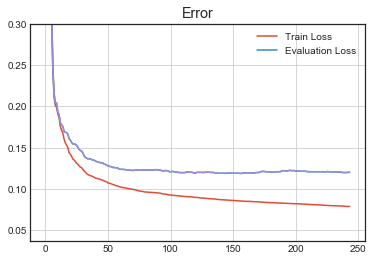

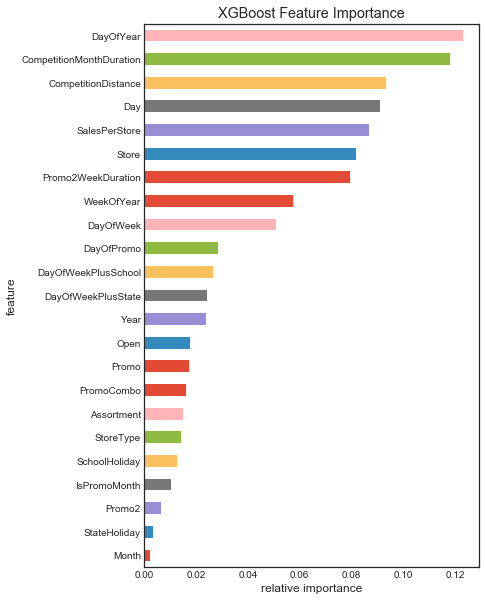

In [17]:
xgboost_start = time.time()


features = [x for x in train_data.columns if x not in ['Sales']]

dtrain = xgb.DMatrix(train_data[features], np.log(train_data["Sales"] + 1))
dvalid = xgb.DMatrix(val_data[features], np.log(val_data["Sales"] + 1))
dtest = xgb.DMatrix(test[features])
watchlist = [(dtrain, 'train'),(dvalid, 'eval')]
params = {"objective": "reg:linear",
          "booster" : "gbtree",
          "eta": 0.4,
          "max_depth": 8,
          "subsample": 0.4,
          "colsample_bytree": 0.9,
          "min_child_weight":8,
          "reg_alpha":1e-03,
          "seed":31,
          "silent": 1
          }
num_trees = 300
res = {}
gbm = xgb.train(params, dtrain, num_trees, evals=watchlist, early_stopping_rounds=100, feval=rmspe, verbose_eval=True,evals_result=res)

print("Validating")
train_probs = gbm.predict(xgb.DMatrix(val_data[features]))
indices = train_probs < 0
train_probs[indices] = 0
error = rmspe_score(np.exp(train_probs) - 1, val_data['Sales'].values)
print('error', error)

#from xgboost import XGBRegressor 
#predictors = [x for x in train_data.columns]
#xgbr = XGBRegressor(learning_rate=0.3,n_estimators=300,silent=1,n_jobs=8,colsample_bytree=0.6,
#                   max_depth=6,min_child_weight=3,subsample=0.7)

#modelfit(xgbr, pd.concat([train_data,sales_train],axis=1), predictors,target='Sales')
xgboost_train_end = time.time() - xgboost_start
#print "XGboost Trained %f" % xgboost_train_end

print("Make predictions on the test set")
test_probs = gbm.predict(xgb.DMatrix(test[features]))
indices = test_probs < 0
test_probs[indices] = 0
submission = pd.DataFrame({"Id": test["Id"], "Sales": np.exp(test_probs) - 1})
submission['Id'] = pd.to_numeric(submission['Id'], downcast='integer')
submission.to_csv("my_submission.csv", index=False)

#org_test_data['Date'] = pd.to_datetime(org_test_data['Date'])
#org_test_data.set_index(['Date','Store'],inplace=True,drop=False)
#org_test_data.sort_index(inplace=True)
#test = build_features(org_test_data)
#not_open_index = test[test['Open']==0].index
#test_train = test.drop(['Id'],axis=1)
#test_result = xgbr.predict(test_train)
#submission = pd.DataFrame({"Id": test['Id'], "Sales": np.expm1(test_result)})
#submission.set_value(not_open_index,"Sales",0.0)
#submission.ix[not_open_index]["Sales"] = 0.0
#submission['Id'] = pd.to_numeric(submission['Id'], downcast='integer')
#display(submission.ix[not_open_index])
#submission.to_csv("my_submission.csv", index=False)

import operator

_,ax = plt.subplots()
evals_res = pd.DataFrame.from_dict(res['eval']).drop(['rmse'],axis=1)
train_res = pd.DataFrame.from_dict(res['train']).drop(['rmse'],axis=1)
x_axis = range(0,len(train_res))

ax.plot(x_axis,train_res['rmspe'],label='Train Loss')
ax.plot(x_axis,evals_res['rmspe'],label='Evaluation Loss')
ax.set_title("Error")
ax.set_ylim(top=0.3)
ax.legend()
ax.grid(True)

plt.plot(evals_res)
create_feature_map(train_data[features])
importance = gbm.get_fscore(fmap='xgb.fmap')
importance = sorted(importance.items(), key=operator.itemgetter(1))

df = pd.DataFrame(importance, columns=['feature', 'fscore'])
df['fscore'] = df['fscore'] / df['fscore'].sum()

featp = df.plot(kind='barh', x='feature', y='fscore', legend=False, figsize=(6, 10))
plt.title('XGBoost Feature Importance')
plt.xlabel('relative importance')

In [4]:
train_data = build_features(org_train_data)
display(train_data.columns)

Index([u'Assortment', u'CompetitionDistance', u'DayOfWeek', u'Open', u'Promo',
       u'Promo2', u'Sales', u'SchoolHoliday', u'StateHoliday', u'Store',
       u'StoreType', u'WeekOfYear', u'DayOfYear', u'Day', u'Month', u'Year',
       u'IsPromoMonth', u'CompetitionMonthDuration', u'Promo2WeekDuration'],
      dtype='object')

In [21]:
xgboost_start = time.time()
predictors = [x for x in train_data.columns if x not in ['Sales']]
dtrain = xgb.DMatrix(train_data[predictors], np.log(train_data["Sales"] + 1))
dvalid = xgb.DMatrix(val_data[predictors], np.log(val_data["Sales"] + 1))
my_cv = TimeSeriesSplit(n_splits=3).split(train_data)
from xgboost import XGBRegressor 

fig_param = {
    'early_stopping_rounds':50,
    'eval_set': [[val_data[predictors],np.log(val_data["Sales"] + 1)]],
    'eval_metric':'rmse', 
}
param_test0 = {
 'max_depth':range(6,12,2),
 'min_child_weight':range(3,10,2)
}

param_test1 = {
 'max_depth':[9,10,11],
 'min_child_weight':[4,5,6]
}

param_test2 = {
 'gamma':[i/10.0 for i in range(0,5)]
}

param_test2_1 = {
 'gamma':[0.15,0.2,0.25]
}

param_test3 = {
 'subsample':[i/10.0 for i in range(6,11)],
 'colsample_bytree':[i/10.0 for i in range(6,11)]
}

param_test4 = {
 'subsample':[i/100.0 for i in range(75,80,5)],
 'colsample_bytree':[i/100.0 for i in range(55,70,5)]
}

param_test5 = {
 'reg_alpha':[1e-5, 1e-2, 0.1, 1, 100]
}

param_test6 = {
 'reg_alpha':[0.005,0.025,0.05]
}


rmspe_scorer = make_scorer(metrics_rmspe,greater_is_better=False)
xgbr = XGBRegressor(learning_rate= 0.3,n_estimators=300,silent=False,n_jobs=4,seed=31,max_depth=10,min_child_weight=5,gamma=0.2,subsample=1.0,colsample_bytree=1.0,reg_alpha=1e-05)
gsearch = GridSearchCV(estimator=xgbr, cv=my_cv,param_grid=param_test5,scoring='neg_mean_squared_error',verbose=10,fit_params=fig_param)

#xgb = XGBRegressor(max_depth=8,learning_rate=0.26,n_estimators=500,silent=False,n_jobs=4)
gsearch.fit(train_data[predictors], np.log(train_data['Sales']+1))
display(gsearch.grid_scores_)
display(gsearch.best_params_)
display(gsearch.best_score_)
xgboost_train_end = time.time() - xgboost_start
print ("XGboost Trained %f" % xgboost_train_end)

Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV] reg_alpha=1e-05 .................................................
[0]	validation_0-rmse:5.40482
Will train until validation_0-rmse hasn't improved in 50 rounds.


/home/ubuntu/anaconda3/envs/python2/lib/python2.7/site-packages/sklearn/model_selection/_search.py:584: DeprecationWarning: "fit_params" as a constructor argument was deprecated in version 0.19 and will be removed in version 0.21. Pass fit parameters to the "fit" method instead.
  '"fit" method instead.', DeprecationWarning)


[1]	validation_0-rmse:3.7844
[2]	validation_0-rmse:2.68479
[3]	validation_0-rmse:1.90827
[4]	validation_0-rmse:1.3777
[5]	validation_0-rmse:1.01925
[6]	validation_0-rmse:0.769742
[7]	validation_0-rmse:0.603326
[8]	validation_0-rmse:0.482884
[9]	validation_0-rmse:0.416308
[10]	validation_0-rmse:0.374237
[11]	validation_0-rmse:0.353492
[12]	validation_0-rmse:0.341556
[13]	validation_0-rmse:0.335922
[14]	validation_0-rmse:0.331596
[15]	validation_0-rmse:0.328064
[16]	validation_0-rmse:0.326853
[17]	validation_0-rmse:0.326105
[18]	validation_0-rmse:0.325479
[19]	validation_0-rmse:0.325031
[20]	validation_0-rmse:0.325036
[21]	validation_0-rmse:0.324926
[22]	validation_0-rmse:0.32443
[23]	validation_0-rmse:0.324544
[24]	validation_0-rmse:0.324836
[25]	validation_0-rmse:0.324771
[26]	validation_0-rmse:0.324865
[27]	validation_0-rmse:0.324739
[28]	validation_0-rmse:0.324262
[29]	validation_0-rmse:0.32443
[30]	validation_0-rmse:0.324499
[31]	validation_0-rmse:0.324495
[32]	validation_0-rmse:0.3

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    9.1s remaining:    0.0s


[0]	validation_0-rmse:5.35808
Will train until validation_0-rmse hasn't improved in 50 rounds.
[1]	validation_0-rmse:3.74549
[2]	validation_0-rmse:2.61943
[3]	validation_0-rmse:1.83211
[4]	validation_0-rmse:1.28462
[5]	validation_0-rmse:0.909714
[6]	validation_0-rmse:0.652751
[7]	validation_0-rmse:0.492429
[8]	validation_0-rmse:0.3927
[9]	validation_0-rmse:0.339948
[10]	validation_0-rmse:0.311423
[11]	validation_0-rmse:0.300625
[12]	validation_0-rmse:0.296608
[13]	validation_0-rmse:0.296646
[14]	validation_0-rmse:0.295681
[15]	validation_0-rmse:0.299172
[16]	validation_0-rmse:0.300148
[17]	validation_0-rmse:0.302152
[18]	validation_0-rmse:0.302805
[19]	validation_0-rmse:0.303333
[20]	validation_0-rmse:0.304591
[21]	validation_0-rmse:0.305135
[22]	validation_0-rmse:0.304995
[23]	validation_0-rmse:0.304698
[24]	validation_0-rmse:0.304953
[25]	validation_0-rmse:0.304463
[26]	validation_0-rmse:0.304228
[27]	validation_0-rmse:0.304685
[28]	validation_0-rmse:0.304812
[29]	validation_0-rmse:0

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   22.3s remaining:    0.0s


[0]	validation_0-rmse:5.37181
Will train until validation_0-rmse hasn't improved in 50 rounds.
[1]	validation_0-rmse:3.76222
[2]	validation_0-rmse:2.6358
[3]	validation_0-rmse:1.85061
[4]	validation_0-rmse:1.30569
[5]	validation_0-rmse:0.915855
[6]	validation_0-rmse:0.656874
[7]	validation_0-rmse:0.48753
[8]	validation_0-rmse:0.376766
[9]	validation_0-rmse:0.307831
[10]	validation_0-rmse:0.271177
[11]	validation_0-rmse:0.252947
[12]	validation_0-rmse:0.242677
[13]	validation_0-rmse:0.234833
[14]	validation_0-rmse:0.233562
[15]	validation_0-rmse:0.23115
[16]	validation_0-rmse:0.230407
[17]	validation_0-rmse:0.230605
[18]	validation_0-rmse:0.230443
[19]	validation_0-rmse:0.23011
[20]	validation_0-rmse:0.229156
[21]	validation_0-rmse:0.228633
[22]	validation_0-rmse:0.22841
[23]	validation_0-rmse:0.228385
[24]	validation_0-rmse:0.22759
[25]	validation_0-rmse:0.227063
[26]	validation_0-rmse:0.226974
[27]	validation_0-rmse:0.226568
[28]	validation_0-rmse:0.226569
[29]	validation_0-rmse:0.226

[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   48.7s remaining:    0.0s


[1]	validation_0-rmse:3.78441
[2]	validation_0-rmse:2.6848
[3]	validation_0-rmse:1.90828
[4]	validation_0-rmse:1.37772
[5]	validation_0-rmse:1.01927
[6]	validation_0-rmse:0.768953
[7]	validation_0-rmse:0.592668
[8]	validation_0-rmse:0.48608
[9]	validation_0-rmse:0.425548
[10]	validation_0-rmse:0.38432
[11]	validation_0-rmse:0.36063
[12]	validation_0-rmse:0.34757
[13]	validation_0-rmse:0.340277
[14]	validation_0-rmse:0.336052
[15]	validation_0-rmse:0.333823
[16]	validation_0-rmse:0.332366
[17]	validation_0-rmse:0.331121
[18]	validation_0-rmse:0.330614
[19]	validation_0-rmse:0.329824
[20]	validation_0-rmse:0.329698
[21]	validation_0-rmse:0.329063
[22]	validation_0-rmse:0.32937
[23]	validation_0-rmse:0.329464
[24]	validation_0-rmse:0.329291
[25]	validation_0-rmse:0.329251
[26]	validation_0-rmse:0.32962
[27]	validation_0-rmse:0.32956
[28]	validation_0-rmse:0.329494
[29]	validation_0-rmse:0.329691
[30]	validation_0-rmse:0.329288
[31]	validation_0-rmse:0.329283
[32]	validation_0-rmse:0.32927

[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   57.0s remaining:    0.0s


[0]	validation_0-rmse:5.35809
Will train until validation_0-rmse hasn't improved in 50 rounds.
[1]	validation_0-rmse:3.74549
[2]	validation_0-rmse:2.61963
[3]	validation_0-rmse:1.83234
[4]	validation_0-rmse:1.28844
[5]	validation_0-rmse:0.910798
[6]	validation_0-rmse:0.654636
[7]	validation_0-rmse:0.49595
[8]	validation_0-rmse:0.396065
[9]	validation_0-rmse:0.344479
[10]	validation_0-rmse:0.32182
[11]	validation_0-rmse:0.31051
[12]	validation_0-rmse:0.30763
[13]	validation_0-rmse:0.308322
[14]	validation_0-rmse:0.31122
[15]	validation_0-rmse:0.312952
[16]	validation_0-rmse:0.313503
[17]	validation_0-rmse:0.314536
[18]	validation_0-rmse:0.315638
[19]	validation_0-rmse:0.315871
[20]	validation_0-rmse:0.316657
[21]	validation_0-rmse:0.317374
[22]	validation_0-rmse:0.317723
[23]	validation_0-rmse:0.316896
[24]	validation_0-rmse:0.318789
[25]	validation_0-rmse:0.318703
[26]	validation_0-rmse:0.319414
[27]	validation_0-rmse:0.319916
[28]	validation_0-rmse:0.319924
[29]	validation_0-rmse:0.32

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  1.2min remaining:    0.0s


[0]	validation_0-rmse:5.37181
Will train until validation_0-rmse hasn't improved in 50 rounds.
[1]	validation_0-rmse:3.76222
[2]	validation_0-rmse:2.63581
[3]	validation_0-rmse:1.85033
[4]	validation_0-rmse:1.3034
[5]	validation_0-rmse:0.922271
[6]	validation_0-rmse:0.657737
[7]	validation_0-rmse:0.485432
[8]	validation_0-rmse:0.374578
[9]	validation_0-rmse:0.311277
[10]	validation_0-rmse:0.276274
[11]	validation_0-rmse:0.260214
[12]	validation_0-rmse:0.25251
[13]	validation_0-rmse:0.245824
[14]	validation_0-rmse:0.244072
[15]	validation_0-rmse:0.24295
[16]	validation_0-rmse:0.242073
[17]	validation_0-rmse:0.240687
[18]	validation_0-rmse:0.237995
[19]	validation_0-rmse:0.239545
[20]	validation_0-rmse:0.238916
[21]	validation_0-rmse:0.238949
[22]	validation_0-rmse:0.238064
[23]	validation_0-rmse:0.237991
[24]	validation_0-rmse:0.238015
[25]	validation_0-rmse:0.238173
[26]	validation_0-rmse:0.237994
[27]	validation_0-rmse:0.234976
[28]	validation_0-rmse:0.234798
[29]	validation_0-rmse:0.

[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:  1.6min remaining:    0.0s


[1]	validation_0-rmse:3.78448
[2]	validation_0-rmse:2.6849
[3]	validation_0-rmse:1.90801
[4]	validation_0-rmse:1.37676
[5]	validation_0-rmse:1.00967
[6]	validation_0-rmse:0.754344
[7]	validation_0-rmse:0.588525
[8]	validation_0-rmse:0.478755
[9]	validation_0-rmse:0.414559
[10]	validation_0-rmse:0.379727
[11]	validation_0-rmse:0.359047
[12]	validation_0-rmse:0.346081
[13]	validation_0-rmse:0.337374
[14]	validation_0-rmse:0.331627
[15]	validation_0-rmse:0.328207
[16]	validation_0-rmse:0.325316
[17]	validation_0-rmse:0.324645
[18]	validation_0-rmse:0.324496
[19]	validation_0-rmse:0.32313
[20]	validation_0-rmse:0.322682
[21]	validation_0-rmse:0.322251
[22]	validation_0-rmse:0.322418
[23]	validation_0-rmse:0.322354
[24]	validation_0-rmse:0.322301
[25]	validation_0-rmse:0.322362
[26]	validation_0-rmse:0.322976
[27]	validation_0-rmse:0.323075
[28]	validation_0-rmse:0.323033
[29]	validation_0-rmse:0.322922
[30]	validation_0-rmse:0.323564
[31]	validation_0-rmse:0.323559
[32]	validation_0-rmse:0

[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:  1.7min remaining:    0.0s


[0]	validation_0-rmse:5.3581
Will train until validation_0-rmse hasn't improved in 50 rounds.
[1]	validation_0-rmse:3.74572
[2]	validation_0-rmse:2.62147
[3]	validation_0-rmse:1.83676
[4]	validation_0-rmse:1.28577
[5]	validation_0-rmse:0.906552
[6]	validation_0-rmse:0.651536
[7]	validation_0-rmse:0.485499
[8]	validation_0-rmse:0.391893
[9]	validation_0-rmse:0.340987
[10]	validation_0-rmse:0.319899
[11]	validation_0-rmse:0.310665
[12]	validation_0-rmse:0.310742
[13]	validation_0-rmse:0.312731
[14]	validation_0-rmse:0.314747
[15]	validation_0-rmse:0.316044
[16]	validation_0-rmse:0.316419
[17]	validation_0-rmse:0.317559
[18]	validation_0-rmse:0.318131
[19]	validation_0-rmse:0.317048
[20]	validation_0-rmse:0.319872
[21]	validation_0-rmse:0.321194
[22]	validation_0-rmse:0.319918
[23]	validation_0-rmse:0.319846
[24]	validation_0-rmse:0.319478
[25]	validation_0-rmse:0.318842
[26]	validation_0-rmse:0.31747
[27]	validation_0-rmse:0.317242
[28]	validation_0-rmse:0.317045
[29]	validation_0-rmse:0

[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:  1.9min remaining:    0.0s


[0]	validation_0-rmse:5.37182
Will train until validation_0-rmse hasn't improved in 50 rounds.
[1]	validation_0-rmse:3.76168
[2]	validation_0-rmse:2.63542
[3]	validation_0-rmse:1.85073
[4]	validation_0-rmse:1.30516
[5]	validation_0-rmse:0.92752
[6]	validation_0-rmse:0.66402
[7]	validation_0-rmse:0.492886
[8]	validation_0-rmse:0.383442
[9]	validation_0-rmse:0.318328
[10]	validation_0-rmse:0.27689
[11]	validation_0-rmse:0.253886
[12]	validation_0-rmse:0.245318
[13]	validation_0-rmse:0.23844
[14]	validation_0-rmse:0.236415
[15]	validation_0-rmse:0.234144
[16]	validation_0-rmse:0.232551
[17]	validation_0-rmse:0.231509
[18]	validation_0-rmse:0.231667
[19]	validation_0-rmse:0.23151
[20]	validation_0-rmse:0.23052
[21]	validation_0-rmse:0.229575
[22]	validation_0-rmse:0.229064
[23]	validation_0-rmse:0.228396
[24]	validation_0-rmse:0.228414
[25]	validation_0-rmse:0.22812
[26]	validation_0-rmse:0.228101
[27]	validation_0-rmse:0.22798
[28]	validation_0-rmse:0.227762
[29]	validation_0-rmse:0.22737

[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:  2.4min remaining:    0.0s


[1]	validation_0-rmse:3.78678
[2]	validation_0-rmse:2.68952
[3]	validation_0-rmse:1.93686
[4]	validation_0-rmse:1.38838
[5]	validation_0-rmse:1.01981
[6]	validation_0-rmse:0.773787
[7]	validation_0-rmse:0.609203
[8]	validation_0-rmse:0.502368
[9]	validation_0-rmse:0.452787
[10]	validation_0-rmse:0.412309
[11]	validation_0-rmse:0.389909
[12]	validation_0-rmse:0.376162
[13]	validation_0-rmse:0.366281
[14]	validation_0-rmse:0.362045
[15]	validation_0-rmse:0.358245
[16]	validation_0-rmse:0.354203
[17]	validation_0-rmse:0.352578
[18]	validation_0-rmse:0.351227
[19]	validation_0-rmse:0.352057
[20]	validation_0-rmse:0.35127
[21]	validation_0-rmse:0.350724
[22]	validation_0-rmse:0.350389
[23]	validation_0-rmse:0.350377
[24]	validation_0-rmse:0.350794
[25]	validation_0-rmse:0.350752
[26]	validation_0-rmse:0.351184
[27]	validation_0-rmse:0.350907
[28]	validation_0-rmse:0.350732
[29]	validation_0-rmse:0.35024
[30]	validation_0-rmse:0.349893
[31]	validation_0-rmse:0.350055
[32]	validation_0-rmse:0

[98]	validation_0-rmse:0.225092
[99]	validation_0-rmse:0.225092
[100]	validation_0-rmse:0.225092
[101]	validation_0-rmse:0.225092
[102]	validation_0-rmse:0.225092
[103]	validation_0-rmse:0.225092
[104]	validation_0-rmse:0.225092
[105]	validation_0-rmse:0.225092
[106]	validation_0-rmse:0.225092
Stopping. Best iteration:
[56]	validation_0-rmse:0.225092

[CV] ............... reg_alpha=1, score=-0.181340473052, total=  24.3s
[CV] reg_alpha=100 ...................................................
[0]	validation_0-rmse:5.37413
Will train until validation_0-rmse hasn't improved in 50 rounds.
[1]	validation_0-rmse:3.77135
[2]	validation_0-rmse:2.65194
[3]	validation_0-rmse:1.87328
[4]	validation_0-rmse:1.33413
[5]	validation_0-rmse:0.965044
[6]	validation_0-rmse:0.813793
[7]	validation_0-rmse:0.644729
[8]	validation_0-rmse:0.547607
[9]	validation_0-rmse:0.465123
[10]	validation_0-rmse:0.424674
[11]	validation_0-rmse:0.417491
[12]	validation_0-rmse:0.414365
[13]	validation_0-rmse:0.409287
[14]	v

[56]	validation_0-rmse:0.285541
[57]	validation_0-rmse:0.285037
[58]	validation_0-rmse:0.284823
[59]	validation_0-rmse:0.284636
[60]	validation_0-rmse:0.284667
[61]	validation_0-rmse:0.284582
[62]	validation_0-rmse:0.284684
[63]	validation_0-rmse:0.284666
[64]	validation_0-rmse:0.284612
[65]	validation_0-rmse:0.284945
[66]	validation_0-rmse:0.28493
[67]	validation_0-rmse:0.284886
[68]	validation_0-rmse:0.284745
[69]	validation_0-rmse:0.284755
[70]	validation_0-rmse:0.284662
[71]	validation_0-rmse:0.284662
[72]	validation_0-rmse:0.284662
[73]	validation_0-rmse:0.284662
[74]	validation_0-rmse:0.284662
[75]	validation_0-rmse:0.284662
[76]	validation_0-rmse:0.284662
[77]	validation_0-rmse:0.284662
[78]	validation_0-rmse:0.284662
[79]	validation_0-rmse:0.284662
[80]	validation_0-rmse:0.284662
[81]	validation_0-rmse:0.284662
[82]	validation_0-rmse:0.284662
[83]	validation_0-rmse:0.284662
[84]	validation_0-rmse:0.284662
[85]	validation_0-rmse:0.284662
[86]	validation_0-rmse:0.284662
[87]	vali

[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:  3.7min finished


[0]	validation_0-rmse:5.37415
Will train until validation_0-rmse hasn't improved in 50 rounds.
[1]	validation_0-rmse:3.77101
[2]	validation_0-rmse:2.64698
[3]	validation_0-rmse:1.86221
[4]	validation_0-rmse:1.31377
[5]	validation_0-rmse:0.933003
[6]	validation_0-rmse:0.670851
[7]	validation_0-rmse:0.4842
[8]	validation_0-rmse:0.366192
[9]	validation_0-rmse:0.281358
[10]	validation_0-rmse:0.22911
[11]	validation_0-rmse:0.202224
[12]	validation_0-rmse:0.180675
[13]	validation_0-rmse:0.173149
[14]	validation_0-rmse:0.165188
[15]	validation_0-rmse:0.158334
[16]	validation_0-rmse:0.156775
[17]	validation_0-rmse:0.155158
[18]	validation_0-rmse:0.154126
[19]	validation_0-rmse:0.15109
[20]	validation_0-rmse:0.149737
[21]	validation_0-rmse:0.145087
[22]	validation_0-rmse:0.144226
[23]	validation_0-rmse:0.143113
[24]	validation_0-rmse:0.143649
[25]	validation_0-rmse:0.142709
[26]	validation_0-rmse:0.138504
[27]	validation_0-rmse:0.137124
[28]	validation_0-rmse:0.138856
[29]	validation_0-rmse:0.1

/home/ubuntu/anaconda3/envs/python2/lib/python2.7/site-packages/sklearn/model_selection/_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


[mean: -0.15202, std: 0.01398, params: {'reg_alpha': 1e-05},
 mean: -0.15994, std: 0.01859, params: {'reg_alpha': 0.01},
 mean: -0.15880, std: 0.01644, params: {'reg_alpha': 0.1},
 mean: -0.17001, std: 0.01369, params: {'reg_alpha': 1},
 mean: -0.20086, std: 0.04178, params: {'reg_alpha': 100}]

{'reg_alpha': 1e-05}

-0.15202352248139586

XGboost Trained 260.254623


Text(0.5,0,'relative importance')

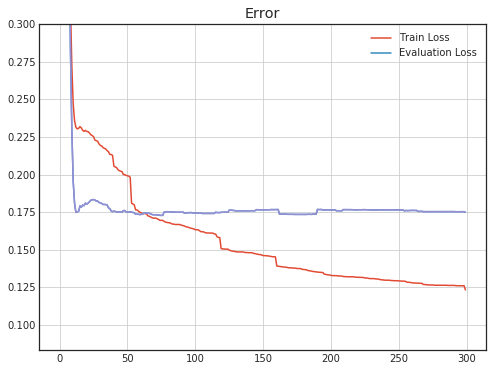

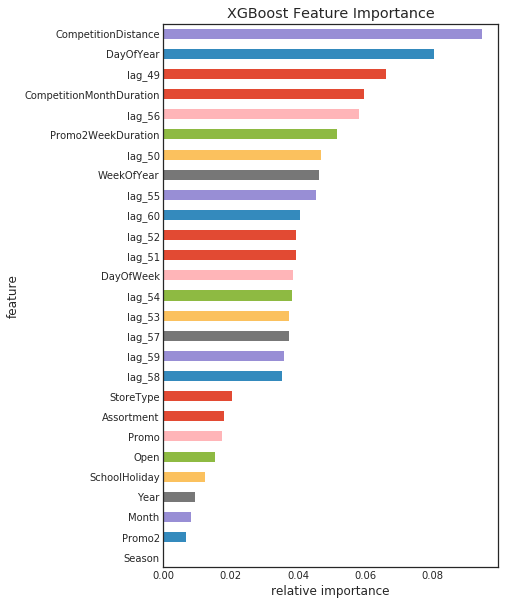

In [175]:
# XGB feature importances
# Based on https://www.kaggle.com/mmueller/liberty-mutual-group-property-inspection-prediction/xgb-feature-importance-python/code
import operator

_,ax = plt.subplots()
evals_res = pd.DataFrame.from_dict(res['eval']).drop(['rmse'],axis=1)
train_res = pd.DataFrame.from_dict(res['train']).drop(['rmse'],axis=1)
x_axis = range(0,len(train_res))

ax.plot(x_axis,train_res['rmspe'],label='Train Loss')
ax.plot(x_axis,evals_res['rmspe'],label='Evaluation Loss')
ax.set_title("Error")
ax.set_ylim(top=0.3)
ax.legend()
ax.grid(True)

plt.plot(evals_res)
create_feature_map(train_data[features])
importance = gbm.get_fscore(fmap='xgb.fmap')
importance = sorted(importance.items(), key=operator.itemgetter(1))

df = pd.DataFrame(importance, columns=['feature', 'fscore'])
df['fscore'] = df['fscore'] / df['fscore'].sum()

featp = df.plot(kind='barh', x='feature', y='fscore', legend=False, figsize=(6, 10))
plt.title('XGBoost Feature Importance')
plt.xlabel('relative importance')
#fig_featp = featp.get_figure()
#fig_featp.savefig('feature_importance_xgb.png', bbox_inches='tight', pad_inches=1)

In [129]:
train_data = build_features(train_data)
val_data = build_features(val_data)
test = build_features(org_test_data)

KeyError: 'Promo2SinceWeek'

In [89]:
display(test.info())

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 41088 entries, (2015-08-01 00:00:00, 1) to (2015-09-17 00:00:00, 1115)
Data columns (total 24 columns):
Assortment                   41088 non-null float64
CompetitionDistance          41088 non-null float64
CompetitionOpenSinceMonth    41088 non-null float64
CompetitionOpenSinceYear     41088 non-null float64
DayOfWeek                    41088 non-null int64
Id                           41088 non-null float64
Open                         41088 non-null float64
Promo                        41088 non-null int64
Promo2                       41088 non-null int64
Promo2SinceWeek              41088 non-null float64
Promo2SinceYear              41088 non-null float64
Sales                        41088 non-null float64
SchoolHoliday                41088 non-null int64
StateHoliday                 41088 non-null float64
StoreType                    41088 non-null float64
isStateHoliday               41088 non-null int64
WeekOfYear              

None

In [64]:
print("Make predictions on the test set")
test_probs = gbm.predict(xgb.DMatrix(test[features]))
indices = test_probs < 0
test_probs[indices] = 0
submission = pd.DataFrame({"Id": test["Id"], "Sales": np.exp(test_probs) - 1})
submission['Id'] = pd.to_numeric(submission['Id'], downcast='integer')
submission.to_csv("my_submission.csv", index=False)

sub = pd.read_csv('./my_submission.csv')
display(sub.info())

Make predictions on the test set
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36808 entries, 0 to 36807
Data columns (total 2 columns):
Id       36808 non-null int64
Sales    36808 non-null float64
dtypes: float64(1), int64(1)
memory usage: 575.2 KB


None

In [ ]:
sales_train = np.log1p(org_train_data[org_train_data['Sales']!=0]['Sales'])
train_data = org_train_data[org_train_data['Sales']!=0].drop('Sales',axis=1)
train_data = build_features(train_data)

In [73]:
display(train_data.columns)

Index([u'CompetitionDistance', u'CompetitionOpenSinceMonth',
       u'CompetitionOpenSinceYear', u'Open', u'Promo', u'Promo2',
       u'Promo2SinceWeek', u'Promo2SinceYear', u'SchoolHoliday',
       u'StateHoliday',
       ...
       u'PromoInterval_Mar,Jun,Sept,Dec', u'PromoInterval_n', u'Month',
       u'Year', u'Week', u'Season', u'CompetitionMonthDuration',
       u'Promo2WeekDuration', u'AllPromo', u'NoPromo'],
      dtype='object', length=121)

In [43]:
#val_start_date = org_train_data.iloc[-1].Date - timedelta(weeks=6)
#mask = (org_train_data['Date'] >= val_start_date) & (org_train_data['Date'] <= org_train_data.iloc[-1].Date)

#split the training data and validation data
#val_data = org_train_data.loc[mask]
#train_data = org_train_data.loc[~mask]


#features_train = train_data[train_data['Sales']!=0].drop('Sales',axis=1)
#sales_train = np.log1p(train_data[train_data['Sales']!=0]['Sales'])

#features_val = val_data[val_data['Sales']!=0].drop('Sales',axis=1)
#sales_val = np.log1p(val_data[val_data['Sales']!=0]['Sales'])

#features_train = build_features(features_train)
#features_val = build_features(features_val)

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
#features_train_scaled = scaler.fit_transform(features_train)
#features_val_scaled = scaler.fit_transform(features_val)

# 将'features'和'val'数据切分成训练集和测试集
#X_train, X_val, y_train, y_val = train_test_split(features_train, sales_train, test_size = 0.1,random_state = 42)

#xgdmat=xgb.DMatrix(features_train,sales_train)
xgboost_start = time.time()
my_cv = TimeSeriesSplit(n_splits=3).split(train_data)
from xgboost import XGBRegressor 

rmspe_scorer = make_scorer(rmspe_score,greater_is_better=False)
xgbr = XGBRegressor('learning_rate': 0.16,n_estimators=140,silent=False,n_jobs=4,'colsample_bytree': 0.6,
                   'max_depth': 6,'min_child_weight': 3,'subsample': 0.7)
gsearch = GridSearchCV(estimator=xgbr, cv=my_cv,
                        param_grid=params,scoring=rmspe_scorer)

#xgb = XGBRegressor(max_depth=8,learning_rate=0.26,n_estimators=500,silent=False,n_jobs=4)
gsearch.fit(train_data, sales_train)
display(gsearch.grid_scores_)
display(gsearch.best_params_)
display(gsearch.best_score_)
xgboost_train_end = time.time() - xgboost_start
print "XGboost Trained %f" % xgboost_train_end

#final_gb=xgb.train(params,xgdmat,num_trees,feval=rmspe_score)
#tesdmat=xgb.DMatrix(features_val)
#y_pred=gsearch.predict(features_val)

#print rmspe_score(sales_val,y_pred)

#reg = LinearRegression()
#reg.fit(X_train,y_train)
#y_pred=reg.predict(X_val)

#print rmspe_score(y_val,y_pred)
#print reg.score(X_val,y_val)

[mean: -0.01705, std: 0.00019, params: {'subsample': 0.6, 'learning_rate': 0.16, 'colsample_bytree': 0.6, 'max_depth': 4, 'min_child_weight': 1},
 mean: -0.01705, std: 0.00016, params: {'subsample': 0.7, 'learning_rate': 0.16, 'colsample_bytree': 0.6, 'max_depth': 4, 'min_child_weight': 1},
 mean: -0.01708, std: 0.00025, params: {'subsample': 0.8, 'learning_rate': 0.16, 'colsample_bytree': 0.6, 'max_depth': 4, 'min_child_weight': 1},
 mean: -0.01708, std: 0.00026, params: {'subsample': 0.9, 'learning_rate': 0.16, 'colsample_bytree': 0.6, 'max_depth': 4, 'min_child_weight': 1},
 mean: -0.01702, std: 0.00016, params: {'subsample': 0.6, 'learning_rate': 0.16, 'colsample_bytree': 0.6, 'max_depth': 4, 'min_child_weight': 3},
 mean: -0.01708, std: 0.00017, params: {'subsample': 0.7, 'learning_rate': 0.16, 'colsample_bytree': 0.6, 'max_depth': 4, 'min_child_weight': 3},
 mean: -0.01711, std: 0.00025, params: {'subsample': 0.8, 'learning_rate': 0.16, 'colsample_bytree': 0.6, 'max_depth': 4, 'm

{'colsample_bytree': 0.6,
 'learning_rate': 0.16,
 'max_depth': 6,
 'min_child_weight': 3,
 'subsample': 0.7}

-0.01573447822116695

XGboost Trained 22131.901303


In [47]:
# XGB feature importances
# Based on https://www.kaggle.com/mmueller/liberty-mutual-group-property-inspection-prediction/xgb-feature-importance-python/code
import operator

create_feature_map(features_train)
importance = xgbr.get_fscore(fmap='xgb.fmap')
importance = sorted(importance.items(), key=operator.itemgetter(1))

df = pd.DataFrame(importance, columns=['feature', 'fscore'])
df['fscore'] = df['fscore'] / df['fscore'].sum()

featp = df.plot(kind='barh', x='feature', y='fscore', legend=False, figsize=(6, 10))
plt.title('XGBoost Feature Importance')
plt.xlabel('relative importance')
#fig_featp = featp.get_figure()
#fig_featp.savefig('feature_importance_xgb.png', bbox_inches='tight', pad_inches=1)

AttributeError: 'XGBRegressor' object has no attribute 'get_fscore'

In [44]:
org_test_data['Date'] = pd.to_datetime(org_test_data['Date'])
org_test_data.set_index(['Date','Store'],inplace=True,drop=False)
org_test_data.sort_index(inplace=True)
test = build_features(org_test_data)
not_open_index = test[test['Open']==0].index
test_train = test.drop(['Id'],axis=1)
test_result = gsearch.predict(test_train)
submission = pd.DataFrame({"Id": test['Id'], "Sales": np.expm1(test_result)})
submission.set_value(not_open_index,"Sales",0.0)
#submission.ix[not_open_index]["Sales"] = 0.0
submission['Id'] = pd.to_numeric(submission['Id'], downcast='integer')
display(submission.ix[not_open_index])
submission.to_csv("my_submission.csv", index=False)

Id  Sales
Date       Store              
2015-08-02 1      39377    0.0
           3      39378    0.0
           7      39379    0.0
           8      39380    0.0
           9      39381    0.0
           10     39382    0.0
           11     39383    0.0
           12     39384    0.0
           13     39385    0.0
           14     39386    0.0
           15     39387    0.0
           16     39388    0.0
           19     39389    0.0
           20     39390    0.0
           21     39391    0.0
           22     39392    0.0
           23     39393    0.0
           24     39394    0.0
           25     39395    0.0
           27     39396    0.0
           29     39397    0.0
           30     39398    0.0
           31     39399    0.0
           32     39400    0.0
           33     39401    0.0
           35     39402    0.0
           36     39403    0.0
           38     39404    0.0
           39     39405    0.0
           40     39406    0.0
...                 ...    ...
2015-09-13 1100    4267    0.0
           1101    4268    0.0
           1102    4269    0.0
           1103    4270    0.0
           1104    4271    0.0
           1105    4272    0.0
           1106    4273    0.0
           1107    4274    0.0
           1109    4275    0.0
           1111    4276    0.0
           1112    4277    0.0
           1113    4278    0.0
           1114    4279    0.0
           1115    4280    0.0
2015-09-14 622     3048    0.0
           703     3112    0.0
           879     3245    0.0
           1097    3409    0.0
2015-09-15 622     2192    0.0
           703     2256    0.0
           879     2389    0.0
           1097    2553    0.0
2015-09-16 622     1336    0.0
           703     1400    0.0
           879     1533    0.0
           1097    1697    0.0
2015-09-17 622      480    0.0
           703      544    0.0
           879      677    0.0
           1097     841    0.0

[5995 rows x 2 columns]


Model Report
RMSPE : 0.0151


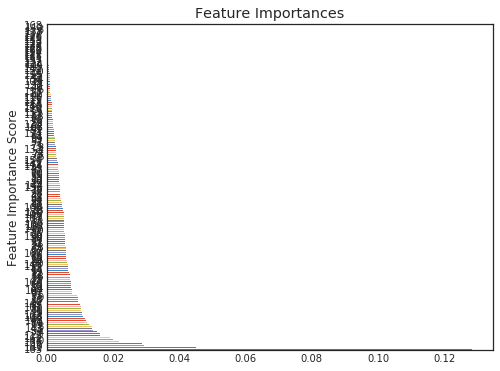

In [83]:
predictors = [x for x in train_data.columns]
xgbr = XGBRegressor(learning_rate=0.01,n_estimators=1000,silent=False,n_jobs=4,colsample_bytree=0.6,
                   max_depth=6,min_child_weight=3,subsample=0.7)

modelfit(xgbr, pd.concat([train_data,sales_train],axis=1), predictors,target='Sales')

In [18]:
xgbr

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.6, gamma=0, learning_rate=0.05, max_delta_step=0,
       max_depth=6, min_child_weight=3, missing=None, n_estimators=500,
       n_jobs=8, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=False, subsample=0.7)

Text(0,0.5,'Feature Importance Score')

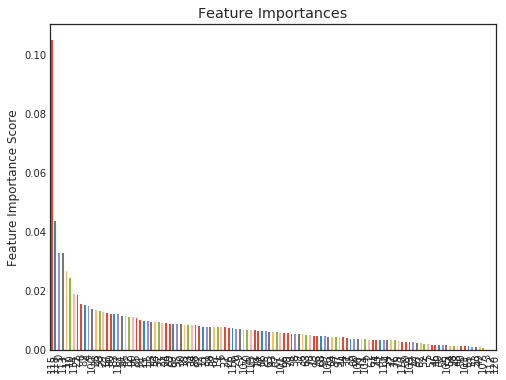

In [68]:
feat_imp = pd.Series(xgbr.feature_importances_).sort_values(ascending=False)
feat_imp.plot(kind='bar', title='Feature Importances')
plt.ylabel('Feature Importance Score')

In [84]:
org_test_data['Date'] = pd.to_datetime(org_test_data['Date'])
org_test_data.set_index(['Date','Store'],inplace=True,drop=False)
org_test_data.sort_index(inplace=True)
test = build_features(org_test_data)
not_open_index = test[test['Open']==0].index
test_train = test.drop(['Id'],axis=1)
test_result = xgbr.predict(test_train)
submission = pd.DataFrame({"Id": test['Id'], "Sales": np.expm1(test_result)})
submission.set_value(not_open_index,"Sales",0.0)
#submission.ix[not_open_index]["Sales"] = 0.0
submission['Id'] = pd.to_numeric(submission['Id'], downcast='integer')
display(submission.ix[not_open_index])
submission.to_csv("my_submission.csv", index=False)

Id  Sales
Date       Store              
2015-08-02 1      39377    0.0
           3      39378    0.0
           7      39379    0.0
           8      39380    0.0
           9      39381    0.0
           10     39382    0.0
           11     39383    0.0
           12     39384    0.0
           13     39385    0.0
           14     39386    0.0
           15     39387    0.0
           16     39388    0.0
           19     39389    0.0
           20     39390    0.0
           21     39391    0.0
           22     39392    0.0
           23     39393    0.0
           24     39394    0.0
           25     39395    0.0
           27     39396    0.0
           29     39397    0.0
           30     39398    0.0
           31     39399    0.0
           32     39400    0.0
           33     39401    0.0
           35     39402    0.0
           36     39403    0.0
           38     39404    0.0
           39     39405    0.0
           40     39406    0.0
...                 ...    ...
2015-09-13 1100    4267    0.0
           1101    4268    0.0
           1102    4269    0.0
           1103    4270    0.0
           1104    4271    0.0
           1105    4272    0.0
           1106    4273    0.0
           1107    4274    0.0
           1109    4275    0.0
           1111    4276    0.0
           1112    4277    0.0
           1113    4278    0.0
           1114    4279    0.0
           1115    4280    0.0
2015-09-14 622     3048    0.0
           703     3112    0.0
           879     3245    0.0
           1097    3409    0.0
2015-09-15 622     2192    0.0
           703     2256    0.0
           879     2389    0.0
           1097    2553    0.0
2015-09-16 622     1336    0.0
           703     1400    0.0
           879     1533    0.0
           1097    1697    0.0
2015-09-17 622      480    0.0
           703      544    0.0
           879      677    0.0
           1097     841    0.0

[5995 rows x 2 columns]

In [107]:
# XGB feature importances
# Based on https://www.kaggle.com/mmueller/liberty-mutual-group-property-inspection-prediction/xgb-feature-importance-python/code
import operator

create_feature_map(features_train)
importance = xgbr.get_fscore(fmap='xgb.fmap')
importance = sorted(importance.items(), key=operator.itemgetter(1))

df = pd.DataFrame(importance, columns=['feature', 'fscore'])
df['fscore'] = df['fscore'] / df['fscore'].sum()

featp = df.plot(kind='barh', x='feature', y='fscore', legend=False, figsize=(6, 10))
plt.title('XGBoost Feature Importance')
plt.xlabel('relative importance')
#fig_featp = featp.get_figure()
#fig_featp.savefig('feature_importance_xgb.png', bbox_inches='tight', pad_inches=1)

AttributeError: 'XGBRegressor' object has no attribute 'get_fscore'

In [101]:
import pandas as pd
import numpy as np
from sklearn import cross_validation
import xgboost as xgb


# Thanks to Chenglong Chen for providing this in the forum
def ToWeight(y):
    w = np.zeros(y.shape, dtype=float)
    ind = y != 0
    w[ind] = 1./(y[ind]**2)
    return w


def rmspe(yhat, y):
    w = ToWeight(y)
    rmspe = np.sqrt(np.mean( w * (y - yhat)**2 ))
    return rmspe

def rmspe_xg(yhat, y):
    # y = y.values
    y = y.get_label()
    y = np.exp(y) - 1
    yhat = np.exp(yhat) - 1
    w = ToWeight(y)
    rmspe = np.sqrt(np.mean(w * (y - yhat)**2))
    return "rmspe", rmspe


# Gather some features
def build_features(features, data):
    # remove NaNs
    data.fillna(0, inplace=True)
    data.loc[data.Open.isnull(), 'Open'] = 1
    # Use some properties directly
    features.extend(['Store', 'CompetitionDistance', 'CompetitionOpenSinceMonth',
                     'CompetitionOpenSinceYear', 'Promo', 'Promo2', 'Promo2SinceWeek', 'Promo2SinceYear'])

    # add some more with a bit of preprocessing
    features.append('SchoolHoliday')
    data['SchoolHoliday'] = data['SchoolHoliday'].astype(float)
    #
    #features.append('StateHoliday')
    #data.loc[data['StateHoliday'] == 'a', 'StateHoliday'] = '1'
    #data.loc[data['StateHoliday'] == 'b', 'StateHoliday'] = '2'
    #data.loc[data['StateHoliday'] == 'c', 'StateHoliday'] = '3'
    #data['StateHoliday'] = data['StateHoliday'].astype(float)

    features.append('DayOfWeek')
    features.append('month')
    features.append('day')
    features.append('year')
    data['year'] = data.Date.apply(lambda x: x.split('-')[0])
    data['year'] = data['year'].astype(float)
    data['month'] = data.Date.apply(lambda x: x.split('-')[1])
    data['month'] = data['month'].astype(float)
    data['day'] = data.Date.apply(lambda x: x.split('-')[2])
    data['day'] = data['day'].astype(float)

    features.append('StoreType')
    data.loc[data['StoreType'] == 'a', 'StoreType'] = '1'
    data.loc[data['StoreType'] == 'b', 'StoreType'] = '2'
    data.loc[data['StoreType'] == 'c', 'StoreType'] = '3'
    data.loc[data['StoreType'] == 'd', 'StoreType'] = '4'
    data['StoreType'] = data['StoreType'].astype(float)

    features.append('Assortment')
    data.loc[data['Assortment'] == 'a', 'Assortment'] = '1'
    data.loc[data['Assortment'] == 'b', 'Assortment'] = '2'
    data.loc[data['Assortment'] == 'c', 'Assortment'] = '3'
    data['Assortment'] = data['Assortment'].astype(float)

print("Load the training, test and store data using pandas")
train = pd.read_csv("./input/train.csv")
test = pd.read_csv("./input/test.csv")
store = pd.read_csv("./input/store.csv")

print("Assume store open, if not provided")
test.fillna(1, inplace=True)

print("Consider only open stores for training. Closed stores wont count into the score.")
train = train[train["Open"] != 0]

print("Join with store")
train = pd.merge(train, store, on='Store')
test = pd.merge(test, store, on='Store')

features = []

print("augment features")
build_features(features, train)
build_features([], test)
print(features)

params = {"objective": "reg:linear",
          "eta": 0.3,
          "max_depth": 8,
          "subsample": 0.7,
          "colsample_bytree": 0.7,
          "silent": 1
          }
num_trees = 300

print("Train a XGBoost model")
val_size = 100000
#train = train.sort(['Date'])
print(train.tail(1)['Date'])
X_train, X_test = cross_validation.train_test_split(train, test_size=0.01)
#X_train, X_test = train.head(len(train) - val_size), train.tail(val_size)
dtrain = xgb.DMatrix(X_train[features], np.log(X_train["Sales"] + 1))
dvalid = xgb.DMatrix(X_test[features], np.log(X_test["Sales"] + 1))
dtest = xgb.DMatrix(test[features])
watchlist = [(dvalid, 'eval'), (dtrain, 'train')]
gbm = xgb.train(params, dtrain, num_trees, evals=watchlist, early_stopping_rounds=50, feval=rmspe_xg, verbose_eval=True)

print("Validating")
train_probs = gbm.predict(xgb.DMatrix(X_test[features]))
indices = train_probs < 0
train_probs[indices] = 0
error = rmspe(np.exp(train_probs) - 1, X_test['Sales'].values)
print('error', error)

print("Make predictions on the test set")
test_probs = gbm.predict(xgb.DMatrix(test[features]))
indices = test_probs < 0
test_probs[indices] = 0
submission = pd.DataFrame({"Id": test["Id"], "Sales": np.exp(test_probs) - 1})
submission.to_csv("my_submission.csv", index=False)


Load the training, test and store data using pandas
Assume store open, if not provided
Consider only open stores for training. Closed stores wont count into the score.
Join with store
augment features
['Store', 'CompetitionDistance', 'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo', 'Promo2', 'Promo2SinceWeek', 'Promo2SinceYear', 'SchoolHoliday', 'DayOfWeek', 'month', 'day', 'year', 'StoreType', 'Assortment']
Train a XGBoost model
844391    2013-01-02
Name: Date, dtype: object
[0]	eval-rmse:5.79641	train-rmse:5.79368	eval-rmspe:0.996847	train-rmspe:0.996808
Multiple eval metrics have been passed: 'train-rmspe' will be used for early stopping.

Will train until train-rmspe hasn't improved in 50 rounds.
[1]	eval-rmse:4.06499	train-rmse:4.06321	eval-rmspe:0.981573	train-rmspe:0.981515
[2]	eval-rmse:2.85536	train-rmse:2.85463	eval-rmspe:0.938006	train-rmspe:0.93796
[3]	eval-rmse:2.0122	train-rmse:2.01214	eval-rmspe:0.856312	train-rmspe:0.85635
[4]	eval-rmse:1.42731	train-rm

[90]	eval-rmse:0.131795	train-rmse:0.142268	eval-rmspe:0.158724	train-rmspe:0.189584
[91]	eval-rmse:0.131167	train-rmse:0.141746	eval-rmspe:0.157987	train-rmspe:0.189178
[92]	eval-rmse:0.131012	train-rmse:0.141551	eval-rmspe:0.157712	train-rmspe:0.189016
[93]	eval-rmse:0.130721	train-rmse:0.141172	eval-rmspe:0.157095	train-rmspe:0.188744
[94]	eval-rmse:0.130305	train-rmse:0.140734	eval-rmspe:0.156668	train-rmspe:0.188336
[95]	eval-rmse:0.130185	train-rmse:0.140605	eval-rmspe:0.156576	train-rmspe:0.188235
[96]	eval-rmse:0.129511	train-rmse:0.140024	eval-rmspe:0.155914	train-rmspe:0.187818
[97]	eval-rmse:0.128846	train-rmse:0.139484	eval-rmspe:0.155074	train-rmspe:0.187214
[98]	eval-rmse:0.128603	train-rmse:0.139265	eval-rmspe:0.154884	train-rmspe:0.18745
[99]	eval-rmse:0.12834	train-rmse:0.138969	eval-rmspe:0.154646	train-rmspe:0.187219
[100]	eval-rmse:0.128063	train-rmse:0.138641	eval-rmspe:0.154374	train-rmspe:0.18681
[101]	eval-rmse:0.127864	train-rmse:0.138379	eval-rmspe:0.154175	tr

[186]	eval-rmse:0.113785	train-rmse:0.121892	eval-rmspe:0.138769	train-rmspe:0.16079
[187]	eval-rmse:0.113748	train-rmse:0.121822	eval-rmspe:0.138756	train-rmspe:0.160609
[188]	eval-rmse:0.113738	train-rmse:0.121801	eval-rmspe:0.138768	train-rmspe:0.160571
[189]	eval-rmse:0.113708	train-rmse:0.121644	eval-rmspe:0.138842	train-rmspe:0.160518
[190]	eval-rmse:0.113541	train-rmse:0.121485	eval-rmspe:0.137948	train-rmspe:0.159578
[191]	eval-rmse:0.11339	train-rmse:0.121379	eval-rmspe:0.137723	train-rmspe:0.159495
[192]	eval-rmse:0.113362	train-rmse:0.121346	eval-rmspe:0.137698	train-rmspe:0.159434
[193]	eval-rmse:0.113296	train-rmse:0.121281	eval-rmspe:0.137709	train-rmspe:0.159392
[194]	eval-rmse:0.113179	train-rmse:0.121187	eval-rmspe:0.137652	train-rmspe:0.159448
[195]	eval-rmse:0.113115	train-rmse:0.121142	eval-rmspe:0.137609	train-rmspe:0.159411
[196]	eval-rmse:0.113052	train-rmse:0.121055	eval-rmspe:0.137578	train-rmspe:0.159318
[197]	eval-rmse:0.112908	train-rmse:0.120889	eval-rmspe:

[282]	eval-rmse:0.108107	train-rmse:0.112608	eval-rmspe:0.132926	train-rmspe:0.147866
[283]	eval-rmse:0.108059	train-rmse:0.112376	eval-rmspe:0.132378	train-rmspe:0.147354
[284]	eval-rmse:0.108002	train-rmse:0.11227	eval-rmspe:0.132335	train-rmspe:0.147111
[285]	eval-rmse:0.107918	train-rmse:0.112223	eval-rmspe:0.132247	train-rmspe:0.147069
[286]	eval-rmse:0.107862	train-rmse:0.112092	eval-rmspe:0.13218	train-rmspe:0.147041
[287]	eval-rmse:0.10784	train-rmse:0.112043	eval-rmspe:0.132181	train-rmspe:0.147012
[288]	eval-rmse:0.108563	train-rmse:0.111888	eval-rmspe:0.132367	train-rmspe:0.147215
[289]	eval-rmse:0.108518	train-rmse:0.111765	eval-rmspe:0.132229	train-rmspe:0.146881
[290]	eval-rmse:0.108446	train-rmse:0.11168	eval-rmspe:0.132277	train-rmspe:0.146824
[291]	eval-rmse:0.108395	train-rmse:0.11164	eval-rmspe:0.13222	train-rmspe:0.146779
[292]	eval-rmse:0.108185	train-rmse:0.111598	eval-rmspe:0.132178	train-rmspe:0.146731
[293]	eval-rmse:0.10814	train-rmse:0.111557	eval-rmspe:0.132

In [42]:
#!/usr/bin/python
from __future__ import print_function
'''
Public Score :  0.11727 (previous 0.11771)
Private Validation Score : [1199]	train-rmspe:0.104377	eval-rmspe:0.093786
'''

import pandas as pd
import numpy as np
from sklearn.cross_validation import train_test_split
import xgboost as xgb

# Gather some features
def build_features(features, data):
    # remove NaNs
    data.fillna(0, inplace=True)
    data.loc[data.Open.isnull(), 'Open'] = 1
    # Use some properties directly
    features.extend(['Store', 'CompetitionDistance', 'Promo', 'Promo2', 'SchoolHoliday'])

    # Label encode some features
    features.extend(['StoreType', 'Assortment', 'StateHoliday'])
    mappings = {'0':0, 'a':1, 'b':2, 'c':3, 'd':4}
    data.StoreType.replace(mappings, inplace=True)
    data.Assortment.replace(mappings, inplace=True)
    data.StateHoliday.replace(mappings, inplace=True)

    features.extend(['DayOfWeek', 'Month', 'Day', 'Year', 'WeekOfYear'])
    data['Year'] = data.Date.dt.year
    data['Month'] = data.Date.dt.month
    data['Day'] = data.Date.dt.day
    data['DayOfWeek'] = data.Date.dt.dayofweek
    data['WeekOfYear'] = data.Date.dt.weekofyear

    # CompetionOpen en PromoOpen from https://www.kaggle.com/ananya77041/rossmann-store-sales/randomforestpython/code
    # Calculate time competition open time in months
    features.append('CompetitionOpen')
    data['CompetitionOpen'] = 12 * (data.Year - data.CompetitionOpenSinceYear) + \
        (data.Month - data.CompetitionOpenSinceMonth)
    # Promo open time in months
    features.append('PromoOpen')
    data['PromoOpen'] = 12 * (data.Year - data.Promo2SinceYear) + \
        (data.WeekOfYear - data.Promo2SinceWeek) / 4.0
    data['PromoOpen'] = data.PromoOpen.apply(lambda x: x if x > 0 else 0)
    data.loc[data.Promo2SinceYear == 0, 'PromoOpen'] = 0

    # Indicate that sales on that day are in promo interval
    features.append('IsPromoMonth')
    month2str = {1:'Jan', 2:'Feb', 3:'Mar', 4:'Apr', 5:'May', 6:'Jun', \
             7:'Jul', 8:'Aug', 9:'Sept', 10:'Oct', 11:'Nov', 12:'Dec'}
    data['monthStr'] = data.Month.map(month2str)
    data.loc[data.PromoInterval == 0, 'PromoInterval'] = ''
    data['IsPromoMonth'] = 0
    for interval in data.PromoInterval.unique():
        if interval != '':
            for month in interval.split(','):
                data.loc[(data.monthStr == month) & (data.PromoInterval == interval), 'IsPromoMonth'] = 1

    return data

## Start of main script

print("Load the training, test and store data using pandas")
types = {'CompetitionOpenSinceYear': np.dtype(int),
         'CompetitionOpenSinceMonth': np.dtype(int),
         'StateHoliday': np.dtype(str),
         'Promo2SinceWeek': np.dtype(int),
         'SchoolHoliday': np.dtype(int),
         'PromoInterval': np.dtype(str)}
train = pd.read_csv("./input/train.csv", parse_dates=[2], dtype=types)
test = pd.read_csv("./input/test.csv", parse_dates=[3], dtype=types)
store = pd.read_csv("./input/store.csv")

print("Assume store open, if not provided")
test.fillna(1, inplace=True)

print("Consider only open stores for training. Closed stores wont count into the score.")
train = train[train["Open"] != 0]
print("Use only Sales bigger then zero")
train = train[train["Sales"] > 0]

print("Join with store")
train = pd.merge(train, store, on='Store')
test = pd.merge(test, store, on='Store')

features = []

print("augment features")
train = build_features(features, train)
test = build_features([], test)
print(features)

print('training data processed')

def rmspe(y, yhat):
    return np.sqrt(np.mean(((y - yhat)/y) ** 2))

def rmspe_xg(yhat, y):
    y = np.expm1(y.get_label())
    yhat = np.expm1(yhat)
    return "rmspe", rmspe(y, yhat)

print("Train xgboost model")

params = {"objective": "reg:linear",
          "booster" : "gbtree",
          "eta": 0.1,
          "max_depth": 10,
          "subsample": 0.85,
          "colsample_bytree": 0.4,
          "min_child_weight": 6,
          "silent": 1,
          "thread": 1,
          "seed": 1301
          }
num_boost_round = 1200

print("Train a XGBoost model")
X_train, X_valid = train_test_split(train, test_size=0.012, random_state=10)
y_train = np.log1p(X_train.Sales)
y_valid = np.log1p(X_valid.Sales)
dtrain = xgb.DMatrix(X_train[features], y_train)
dvalid = xgb.DMatrix(X_valid[features], y_valid)

watchlist = [(dtrain, 'train'), (dvalid, 'eval')]
res = {}
gbm = xgb.train(params, dtrain, num_boost_round, evals=watchlist, early_stopping_rounds=200, \
  feval=rmspe_xg, verbose_eval=True,evals_result=res)

print("Validating")
yhat = gbm.predict(xgb.DMatrix(X_valid[features]))
error = rmspe(X_valid.Sales.values, np.expm1(yhat))
print('RMSPE: {:.6f}'.format(error))

print("Make predictions on the test set")
dtest = xgb.DMatrix(test[features])
test_probs = gbm.predict(dtest)
# Make Submission
result = pd.DataFrame({"Id": test["Id"], 'Sales': np.expm1(test_probs)})
result.to_csv("xgboost_39_submission.csv", index=False)

# XGB feature importances
# Based on https://www.kaggle.com/mmueller/liberty-mutual-group-property-inspection-prediction/xgb-feature-importance-python/code
import operator

_,ax = plt.subplots()
evals_res = pd.DataFrame.from_dict(res['eval']).drop(['rmse'],axis=1)
train_res = pd.DataFrame.from_dict(res['train']).drop(['rmse'],axis=1)
x_axis = range(0,len(train_res))

ax.plot(x_axis,train_res['rmspe'],label='Train Loss')
ax.plot(x_axis,evals_res['rmspe'],label='Evaluation Loss')
ax.set_title("Error")
ax.set_ylim(top=0.3)
ax.legend()
ax.grid(True)

plt.plot(evals_res)
create_feature_map(X_train[features])
importance = gbm.get_fscore(fmap='xgb.fmap')
importance = sorted(importance.items(), key=operator.itemgetter(1))

df = pd.DataFrame(importance, columns=['feature', 'fscore'])
df['fscore'] = df['fscore'] / df['fscore'].sum()

featp = df.plot(kind='barh', x='feature', y='fscore', legend=False, figsize=(6, 10))
plt.title('XGBoost Feature Importance')
plt.xlabel('relative importance')
#fig_featp = featp.get_figure()
#fig_featp.savefig('feature_importance_xgb.png', bbox_inches='tight', pad_inches=1)


Load the training, test and store data using pandas
Assume store open, if not provided
Consider only open stores for training. Closed stores wont count into the score.
Use only Sales bigger then zero
Join with store
augment features
['Store', 'CompetitionDistance', 'Promo', 'Promo2', 'SchoolHoliday', 'StoreType', 'Assortment', 'StateHoliday', 'DayOfWeek', 'Month', 'Day', 'Year', 'WeekOfYear', 'CompetitionOpen', 'PromoOpen', 'IsPromoMonth']
training data processed
Train xgboost model
Train a XGBoost model
[0]	train-rmse:7.44392	eval-rmse:7.44266	train-rmspe:0.999524	eval-rmspe:0.999523
Multiple eval metrics have been passed: 'eval-rmspe' will be used for early stopping.

Will train until eval-rmspe hasn't improved in 200 rounds.
[1]	train-rmse:6.70184	eval-rmse:6.70066	train-rmspe:0.998811	eval-rmspe:0.99881
[2]	train-rmse:6.03406	eval-rmse:6.03321	train-rmspe:0.997522	eval-rmspe:0.997519
[3]	train-rmse:5.43339	eval-rmse:5.4327	train-rmspe:0.995342	eval-rmspe:0.995336
[4]	train-rmse:4.8

KeyboardInterrupt: 

Text(0.5,0,'relative importance')

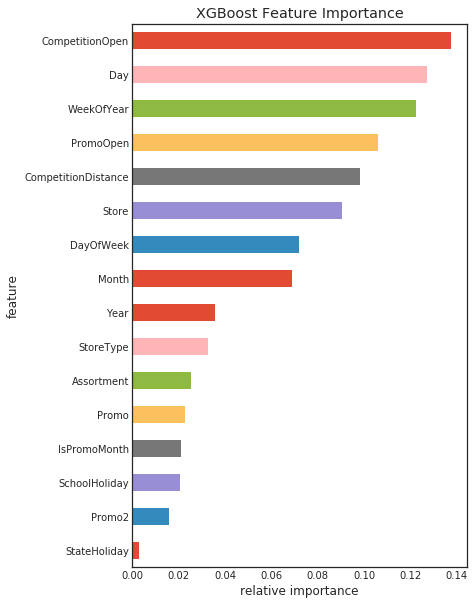

In [193]:
create_feature_map(X_train[features])
importance = gbm.get_fscore(fmap='xgb.fmap')
importance = sorted(importance.items(), key=operator.itemgetter(1))

df = pd.DataFrame(importance, columns=['feature', 'fscore'])
df['fscore'] = df['fscore'] / df['fscore'].sum()

featp = df.plot(kind='barh', x='feature', y='fscore', legend=False, figsize=(6, 10))
plt.title('XGBoost Feature Importance')
plt.xlabel('relative importance')
#fig_featp = featp.get_figure()
#fig_featp.savefig('feature_importance_xgb.png', bbox_inches='tight', pad_inches=1)
